## Прогнозирование временных рядов

In [ ]:
# !pip install etna[all]==2.6.0
# !pip install gdown==5.1.0

In [ ]:
import warnings
import gdown
import pandas as pd
import numpy as np
from copy import deepcopy

warnings.filterwarnings("ignore")

Задача - прогнозирование объема необходимой наличности в банкоматах.

Отсутствие необходимой суммы в банкомате не делает клиента банка счастливее, а избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса.

В качестве инструмента была использована библиотека ETNA: [документация](https://docs.etna.ai/stable/), и [чат](https://t.me/etna_support) комьюнити.

#### Данные

Были использованы дневные данные реальных банкоматов (мультисегментный датасет).

In [ ]:
url = 'https://gist.githubusercontent.com/Polzovat123/4d6d5e544e93429c2d3db29196e9c918/raw/24b27e60f587128d71678e267f51cd48472c6a84/atms_daily_cash.csv'
output = 'atms_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atms_daily_cash.csv', index_col=False)

Downloading...
From: https://gist.githubusercontent.com/Polzovat123/4d6d5e544e93429c2d3db29196e9c918/raw/24b27e60f587128d71678e267f51cd48472c6a84/atms_daily_cash.csv
To: /content/atms_daily_cash.csv
100%|██████████| 258k/258k [00:00<00:00, 4.93MB/s]


In [ ]:
df.head()

datetime  atm_id  operation_value
0  2017-08-16      74         2.059266
1  2017-08-17      74         1.029633
2  2017-08-18      74         0.686422
3  2017-08-19      74        33.301267
4  2017-08-20      74       -12.237921

#### EDA

Построение графиков, по которым можно судить о наличии тренда, сезонности и прочих зависимостей. Анализ корреляций.

[Туториал по EDA при помощи ETNA](https://docs.etna.ai/stable/tutorials/103-EDA.html#EDA).

In [ ]:
from etna.datasets import TSDataset

In [ ]:
def original_tsdataset(df):

    original_df = df.copy(deep=True)
    original_df['timestamp'] = pd.to_datetime(original_df['datetime'])
    original_df['target'] = original_df['operation_value']
    original_df['segment'] = original_df['atm_id']
    original_df.drop(columns=['datetime', 'operation_value', 'atm_id'], inplace=True)
    tsdataset = TSDataset.to_dataset(original_df)
    ts = TSDataset(tsdataset, freq="D")
    return original_df, ts

In [ ]:
tsdataset, ts = original_tsdataset(df)
tsdataset.head()

timestamp     target  segment
0 2017-08-16   2.059266       74
1 2017-08-17   1.029633       74
2 2017-08-18   0.686422       74
3 2017-08-19  33.301267       74
4 2017-08-20 -12.237921       74

In [ ]:
ts.head()

segment       100    101    102    103    104    105    106     74     85  \
feature    target target target target target target target target target   
timestamp                                                                   
2017-06-09    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-10    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-11    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-12    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-13    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

segment        86         87     88     90     91     93     94     96     97  \
feature    target     target target target target target target target target   
timestamp                                                                       
2017-06-09    NaN   0.617780    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-10    NaN   1.441486    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-11    NaN  -0.235345    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-12    NaN -13.532317    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-13    NaN   7.398647    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

segment        98     99  
feature    target target  
timestamp                 
2017-06-09    NaN    NaN  
2017-06-10    NaN    NaN  
2017-06-11    NaN    NaN  
2017-06-12    NaN    NaN  
2017-06-13    NaN    NaN

In [ ]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 20
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
100           2017-08-11    2018-09-30     416            3
101           2017-08-11    2018-09-30     416            3
102           2017-08-02    2018-09-30     425            3
103           2017-08-08    2018-09-30     419            3
104           2017-08-07    2018-09-30     420            3
105           2017-07-28    2018-09-30     430            3
106           2017-08-09    2018-09-30     418            3
74            2017-08-16    2018-09-30     411            3
85            2017-08-03    2018-09-30     424            3
86            2017-08-01    2018-09-30     426            3
87            2017-06-09    2018-09-30     479            3
88            2017-08-14    2018-09-30     413            3
90            2017-07-27    2018-09-30     431    

В датасете имеются записи значений 20 сегментов в течение примерно одного года и одного месяца (для некоторых сегментов период наблюдений больше). Начальное время и, соответственно, количество наблюдений для разных сегментов различаются. В каждом сегменте есть 3 пропущенных значения.

In [ ]:
# ts.describe()

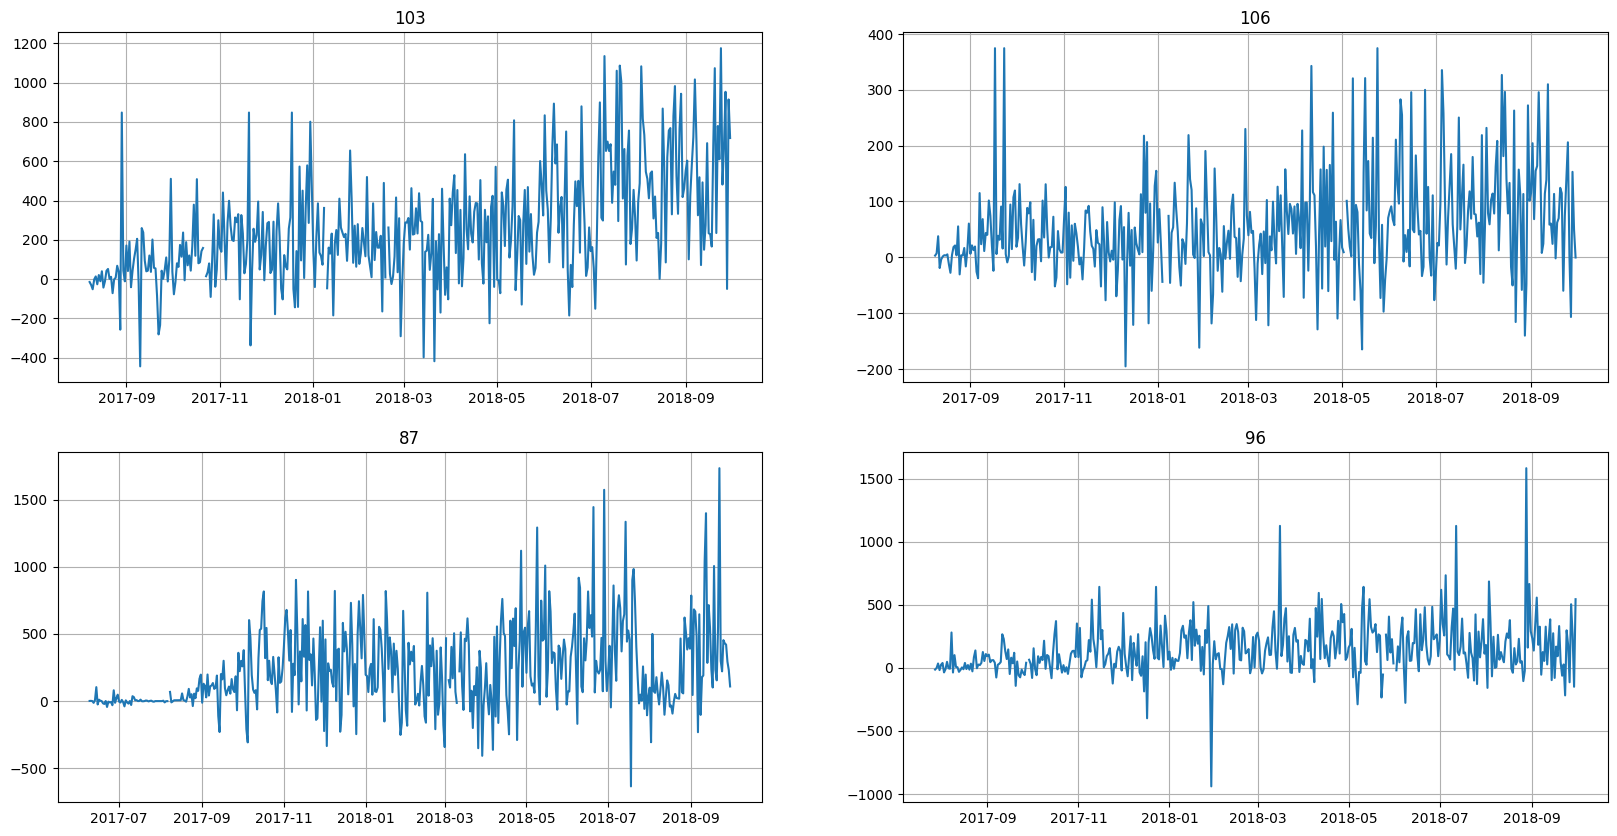

In [ ]:
# сначала посмотрим на сырые данные
# уже по этим графикам можно увидеть возрастающий тренд в каждом сегменте

ts.plot(n_segments=4) # в целях экономии места и памяти на всех графиках в данном ноутбуке были выведены только несколько сегментов
# (однако поставив n_segments=20, можно посмотреть на все сегменты, что и было сделано при анализе - выводы были сделаны после отрисовки всех сегментов)

In [ ]:
from etna.analysis import plot_trend
from etna.transforms import LinearTrendTransform

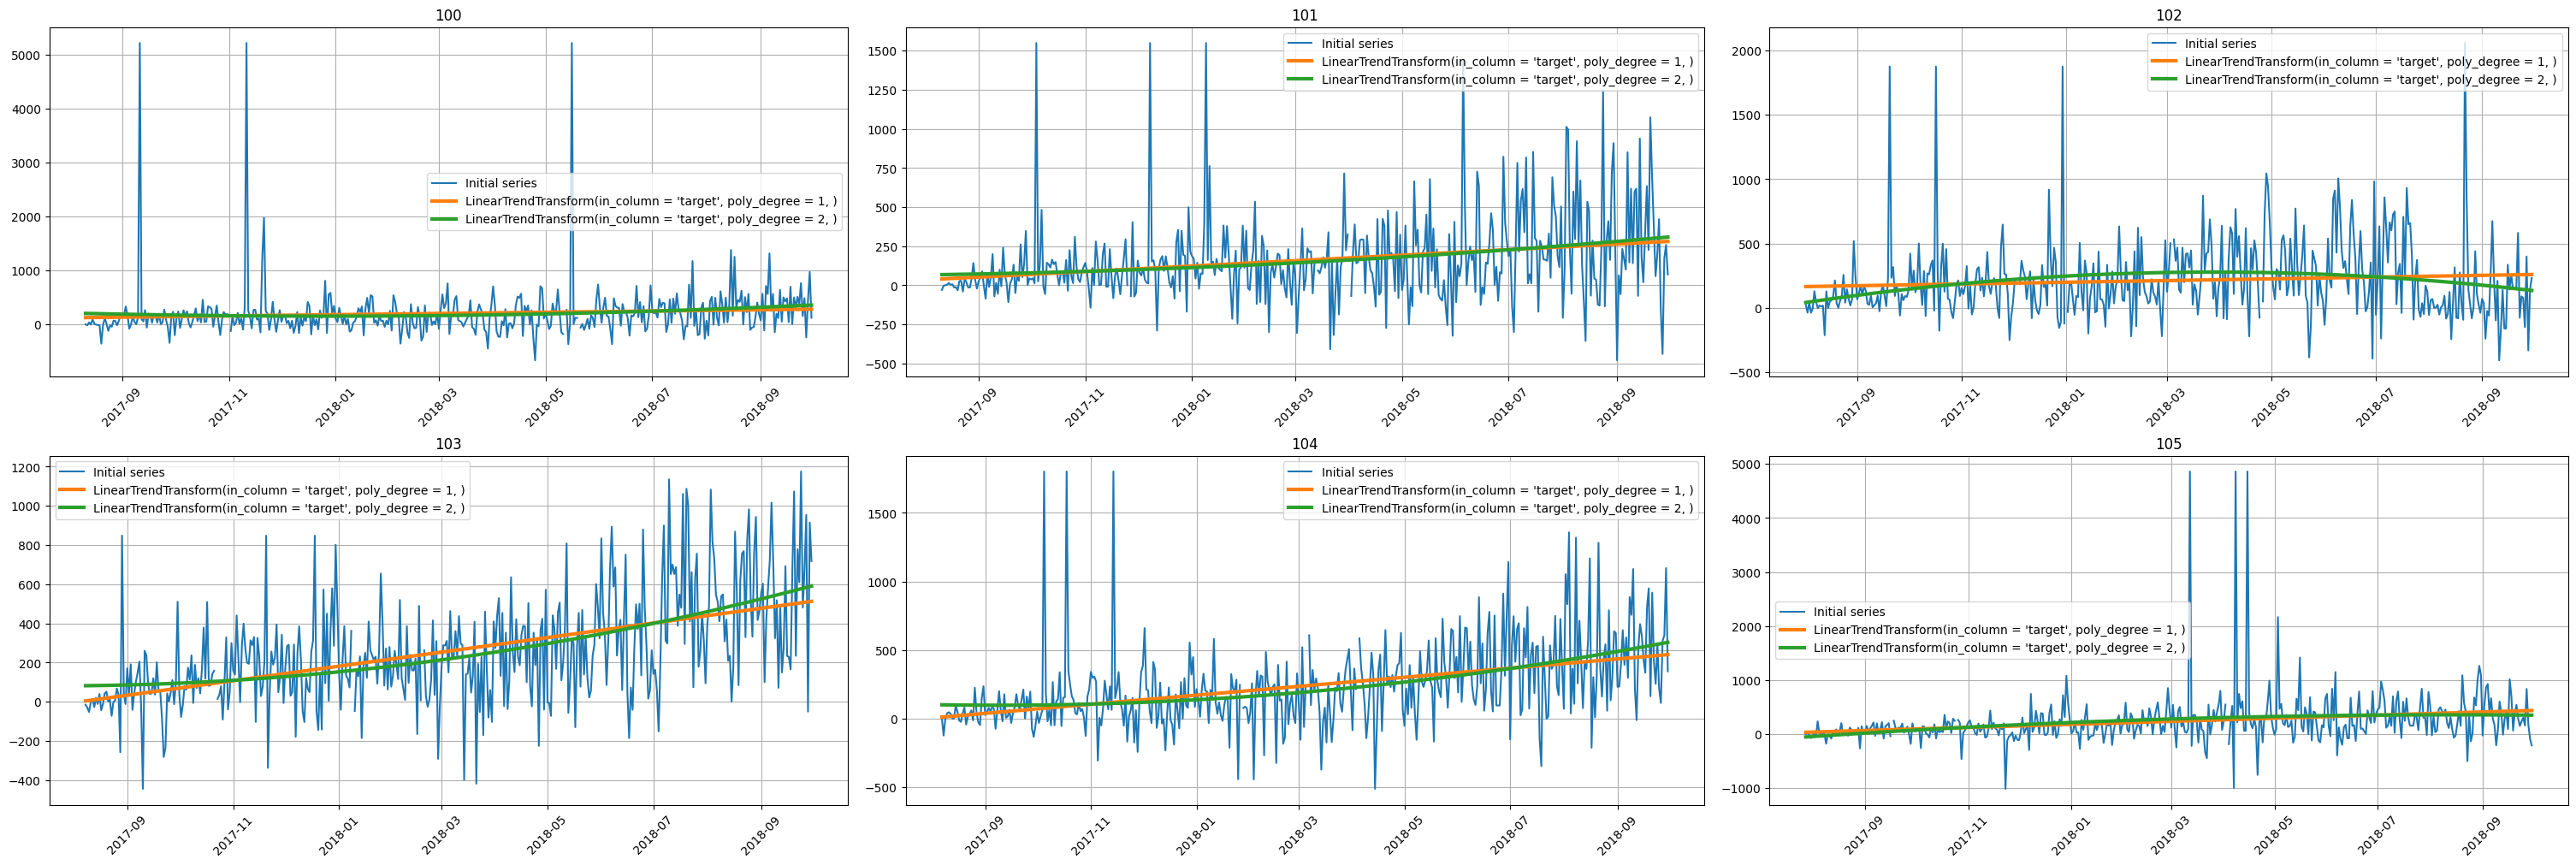

In [ ]:
# явно нарисуем тренды - линейный и параболический

trends = [
    LinearTrendTransform(in_column="target", poly_degree=1),
    LinearTrendTransform(in_column="target", poly_degree=2),
]
plot_trend(ts, trend_transform=trends, columns_num=3, segments=['100', '101', '102', '103', '104', '105'])

# во всех сегментах наблюдается линейный возрастающий тренд, почти совпадающий с параболическим, однако величина наклона тренда различается для разных сегментов

In [ ]:
from etna.analysis import seasonal_plot

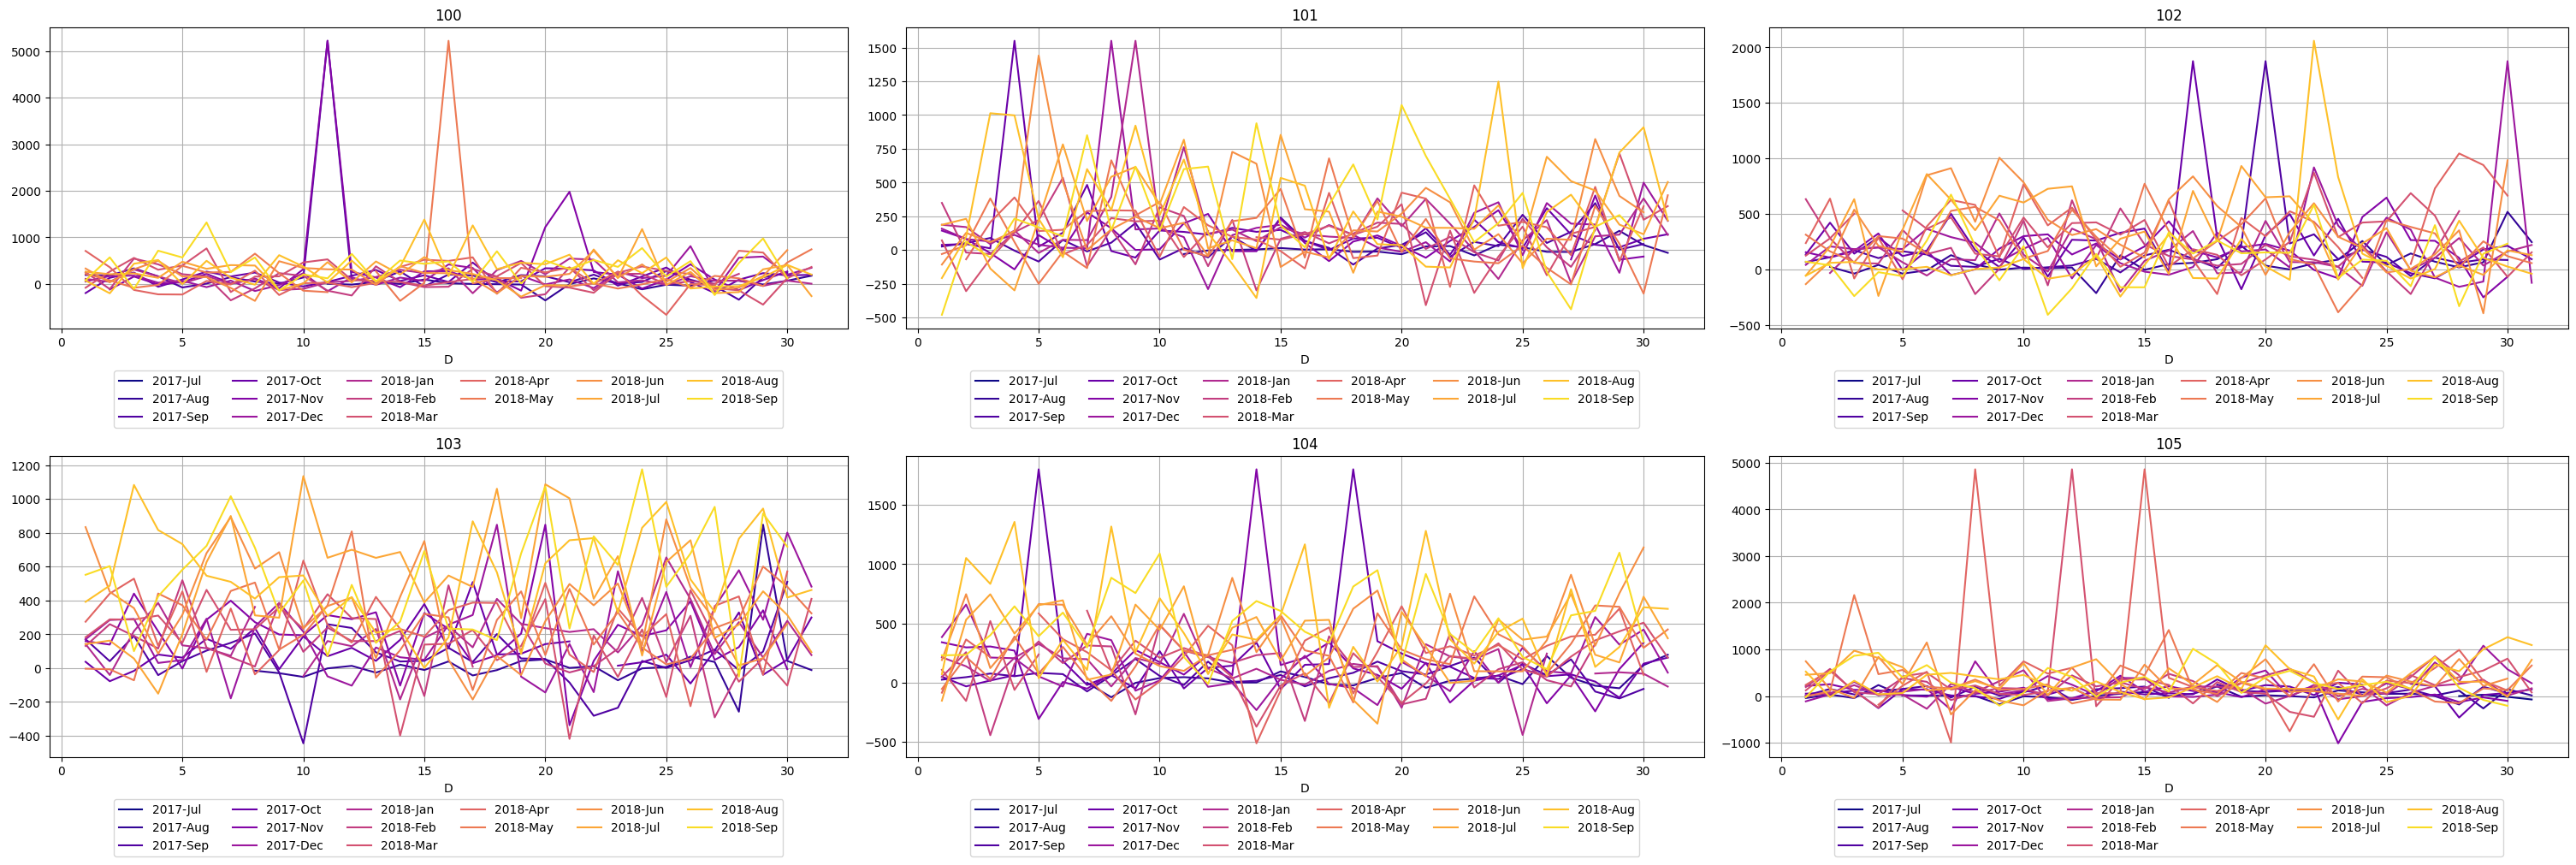

In [ ]:
# гипотеза: в данных может быть месячная сезонность, которая связана с выплатой з/п

seasonal_plot(ts=ts, cycle="month", columns_num=3, segments=['100', '101', '102', '103', '104', '105'])

# по графикам гипотезу опровергла, так как не наблюдается схожих месячных паттернов

In [ ]:
from etna.analysis import plot_correlation_matrix

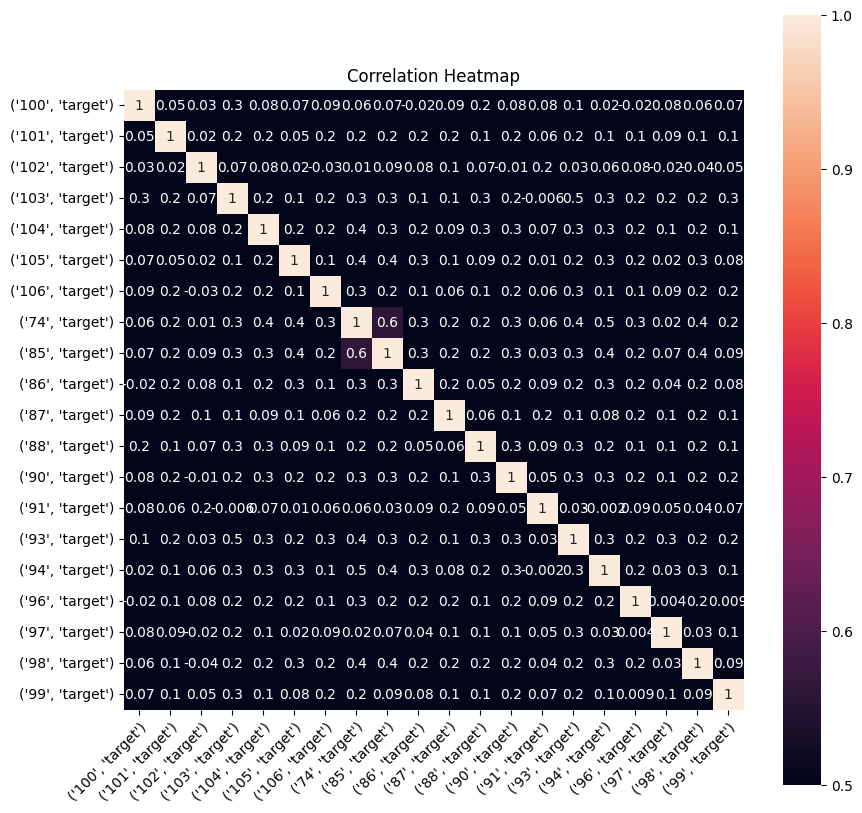

In [ ]:
# посмотрим на корреляции между рядами, потому что operation values у разных банкоматов могут коррелировать,
# если эти банкоматы расположены рядом / в местах с одинаковой проходимостью

plot_correlation_matrix(ts, method="spearman", vmin=0.5, vmax=1)

# таргетные значения не скоррелированы для всех сегментов, кроме 74 и 85

In [ ]:
from etna.transforms import LagTransform

In [ ]:
# построение лагов
lags = LagTransform(in_column="target", lags=[1, 7, 14, 30, 60], out_column="lag")
ts.fit_transform([lags])

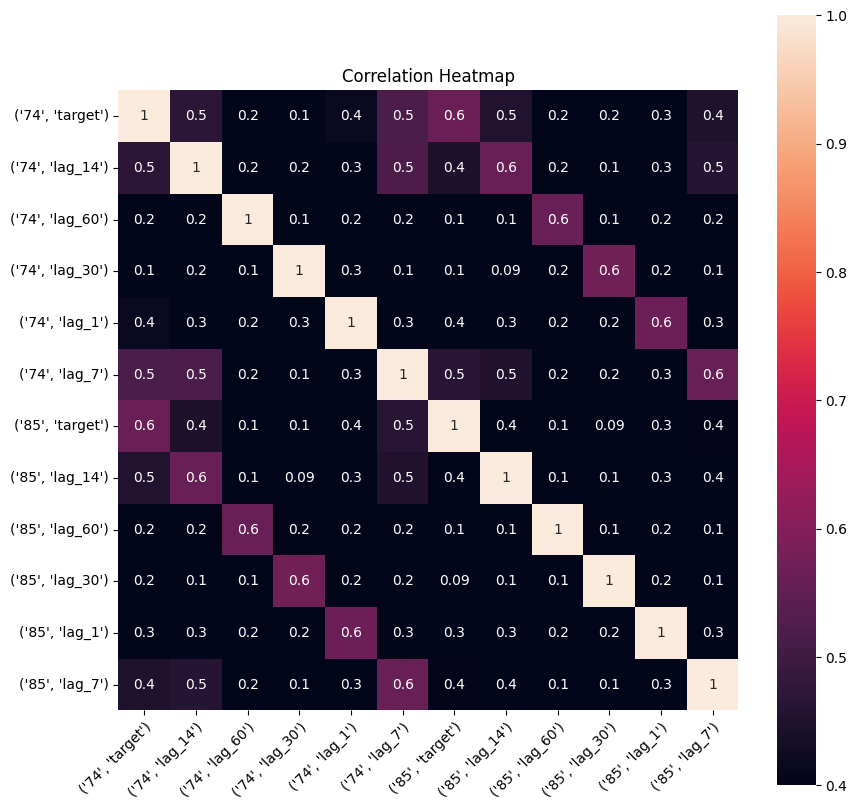

In [ ]:
plot_correlation_matrix(ts, segments=['74', '85'], method="spearman", vmin=0.4, vmax=1)

# есть корреляции между 1, 7, 14, 30 и 60 лагами 74 и 85 сегментов
# также у 74 сегмента есть корреляции с 7 и 14 лагами, что указывает на недельную сезонность

In [ ]:
from etna.analysis import acf_plot

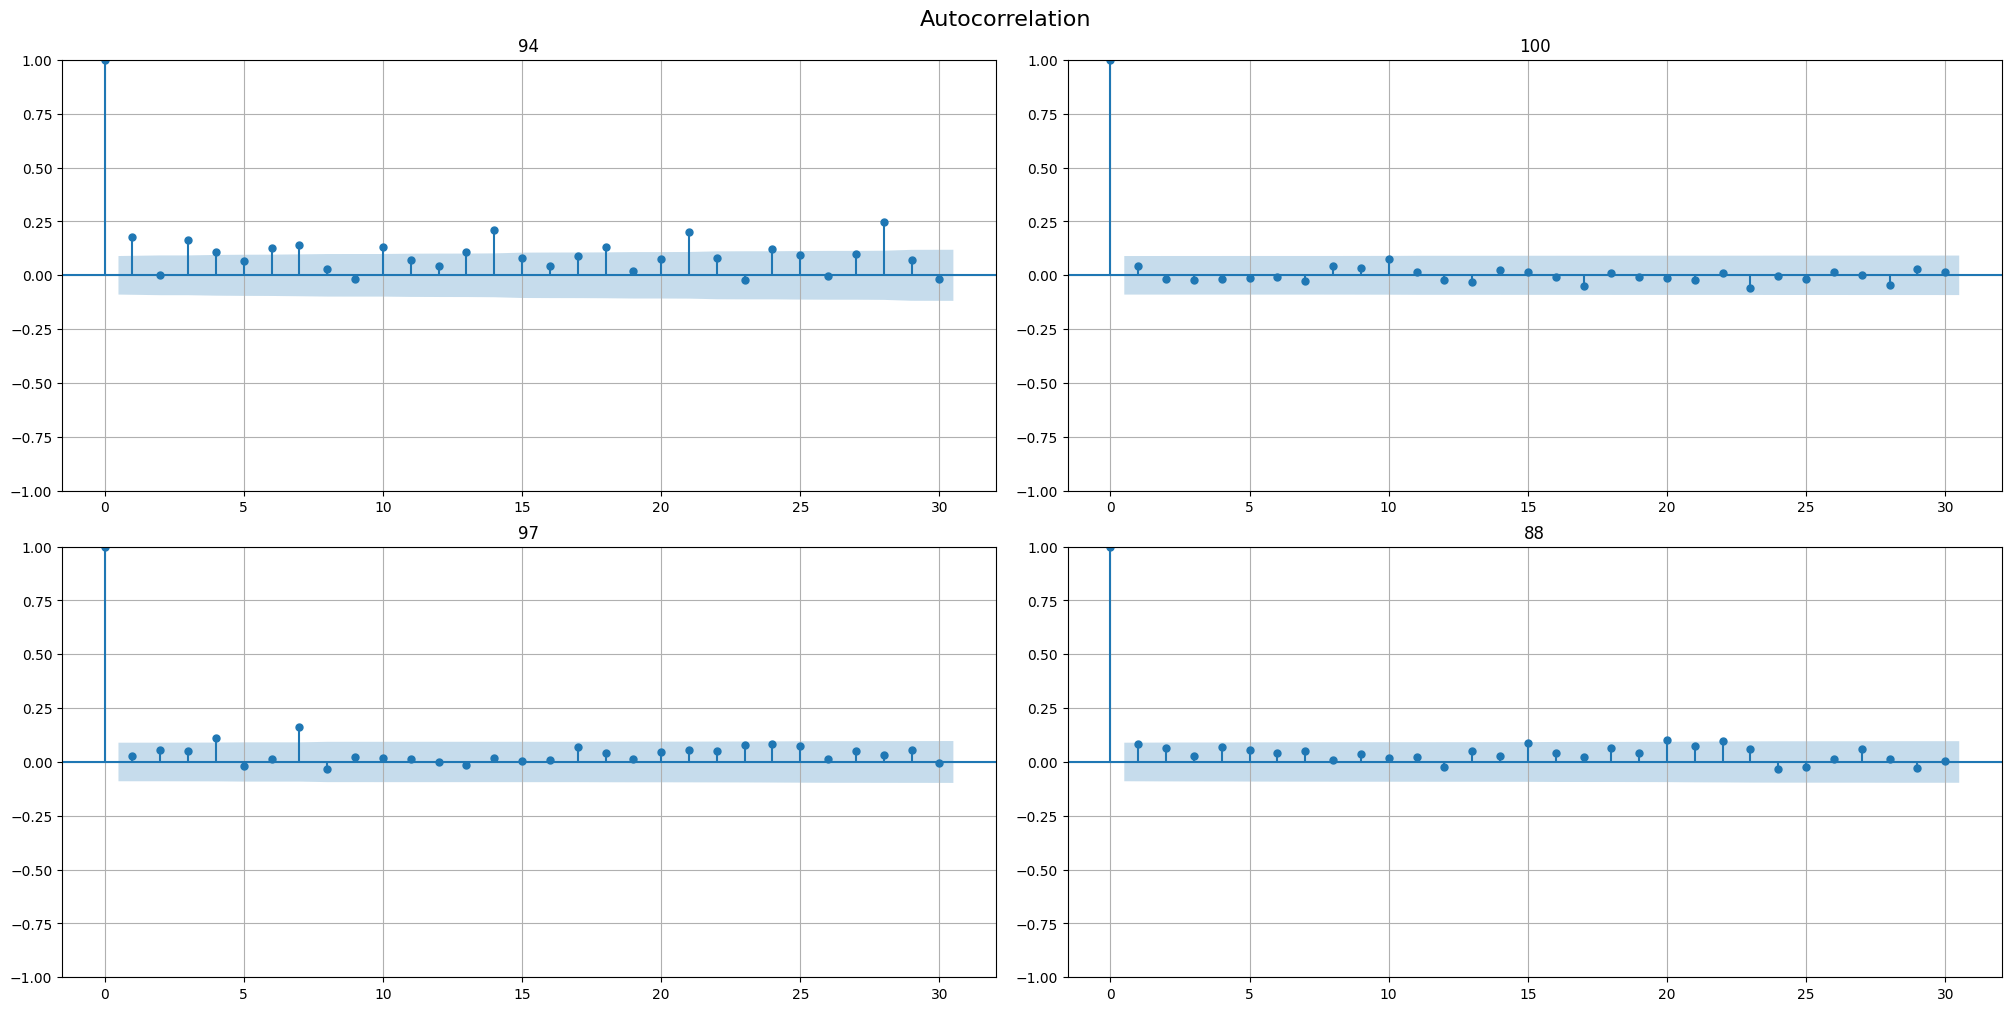

In [ ]:
# посмотрим еще на автокорреляции внутри каждого ряда
_, ts = original_tsdataset(df)
acf_plot(ts, lags=30, n_segments=4)

Нет явной и одинаковой лаговой зависимости внутри сегментов:
- только у некоторых сегментов (85, 105, 103, 74) есть корреляция с 7 лагом (слабая недельная сезонность), причем для 85 сегмента есть корреляции со всеми лагами, кратными 7
- у некоторых рядов (87, 103, 85) есть корреляция с 1 лагом, но все корреляции достаточно слабые (меньше 0.5)
- у 91, 100, 88, 96, 86, 102, 101, 99 сегментов значения корреляций почти не выходят за пределы синего окна (почти отсутствуют лаговые корреляции)
- в некоторых сегментах наблюдаются корреляции, пусть даже и небольшие, с большинством лагов (103, 93, 87, 104, 90)

Выводы:

- тренд во всех сегментах линейный возрастающий
- явной сезонности, общей для всех сегментов, не наблюдается
- в рядах в принципе не наблюдается каких-то явных паттернов
- корреляции есть только между двумя сегментами (74 и 85) и их лагами
- лаговые корреляции внутри сегментов слабые
- для разных сегментов есть разные корреляции с лагами: внутри некоторых сегментов есть корреляции с 1 и 7 лагами


#### Работа с пропущенными значениями и выбросами

**Подбор оптимального метода заполнения пропусков средствами ETNA**

In [ ]:
# еще раз посмотрим на исходный датасет для заполнения пропусков
_, ts_filled_nans = original_tsdataset(df)
ts_filled_nans.head()

segment       100    101    102    103    104    105    106     74     85  \
feature    target target target target target target target target target   
timestamp                                                                   
2017-06-09    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-10    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-11    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-12    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-13    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

segment        86         87     88     90     91     93     94     96     97  \
feature    target     target target target target target target target target   
timestamp                                                                       
2017-06-09    NaN   0.617780    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-10    NaN   1.441486    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-11    NaN  -0.235345    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-12    NaN -13.532317    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-13    NaN   7.398647    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

segment        98     99  
feature    target target  
timestamp                 
2017-06-09    NaN    NaN  
2017-06-10    NaN    NaN  
2017-06-11    NaN    NaN  
2017-06-12    NaN    NaN  
2017-06-13    NaN    NaN

Будем сохранять заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (данные с нерегулярными интервалами) может принести лучший результат.

In [ ]:
ts_filled_nans.info()

# в каждом сегменте есть 3 пропущенных значения
# это небольшое количество пропусков в рамках отдельно взятых сегментов, поэтому по сути не так уж и важно, как они будут заполнены

<class 'etna.datasets.TSDataset'>
num_segments: 20
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
100           2017-08-11    2018-09-30     416            3
101           2017-08-11    2018-09-30     416            3
102           2017-08-02    2018-09-30     425            3
103           2017-08-08    2018-09-30     419            3
104           2017-08-07    2018-09-30     420            3
105           2017-07-28    2018-09-30     430            3
106           2017-08-09    2018-09-30     418            3
74            2017-08-16    2018-09-30     411            3
85            2017-08-03    2018-09-30     424            3
86            2017-08-01    2018-09-30     426            3
87            2017-06-09    2018-09-30     479            3
88            2017-08-14    2018-09-30     413            3
90            2017-07-27    2018-09-30     431    

In [ ]:
from etna.transforms import TimeSeriesImputerTransform
from etna.analysis import plot_imputation

1) заполнять пропуски константой, например нулем, довольно странно, потому что мы не знаем, по каким причинам возникли пропуски в данных: может быть в эти дни банкоматы не работали, и тогда, действительно, их operation values могли быть нулевыми, однако может быть в дни с пропусками данные просто не были записаны

2) заполнять пропуски средним значением или медианным значением не очень хорошо, потому что все ряды имеют довольно высокую дисперсию

3) заполняя пропуски последним известным значением, делается предположение о том, что значения не отличаются для двух дней - грубое предположение, поэтому тоже плохо

4) лучше всего заполнять скользящим средним в каком-то небольшом окне, например, 30 (месяц), это и логично, и сохраним текущий тренд в ряду

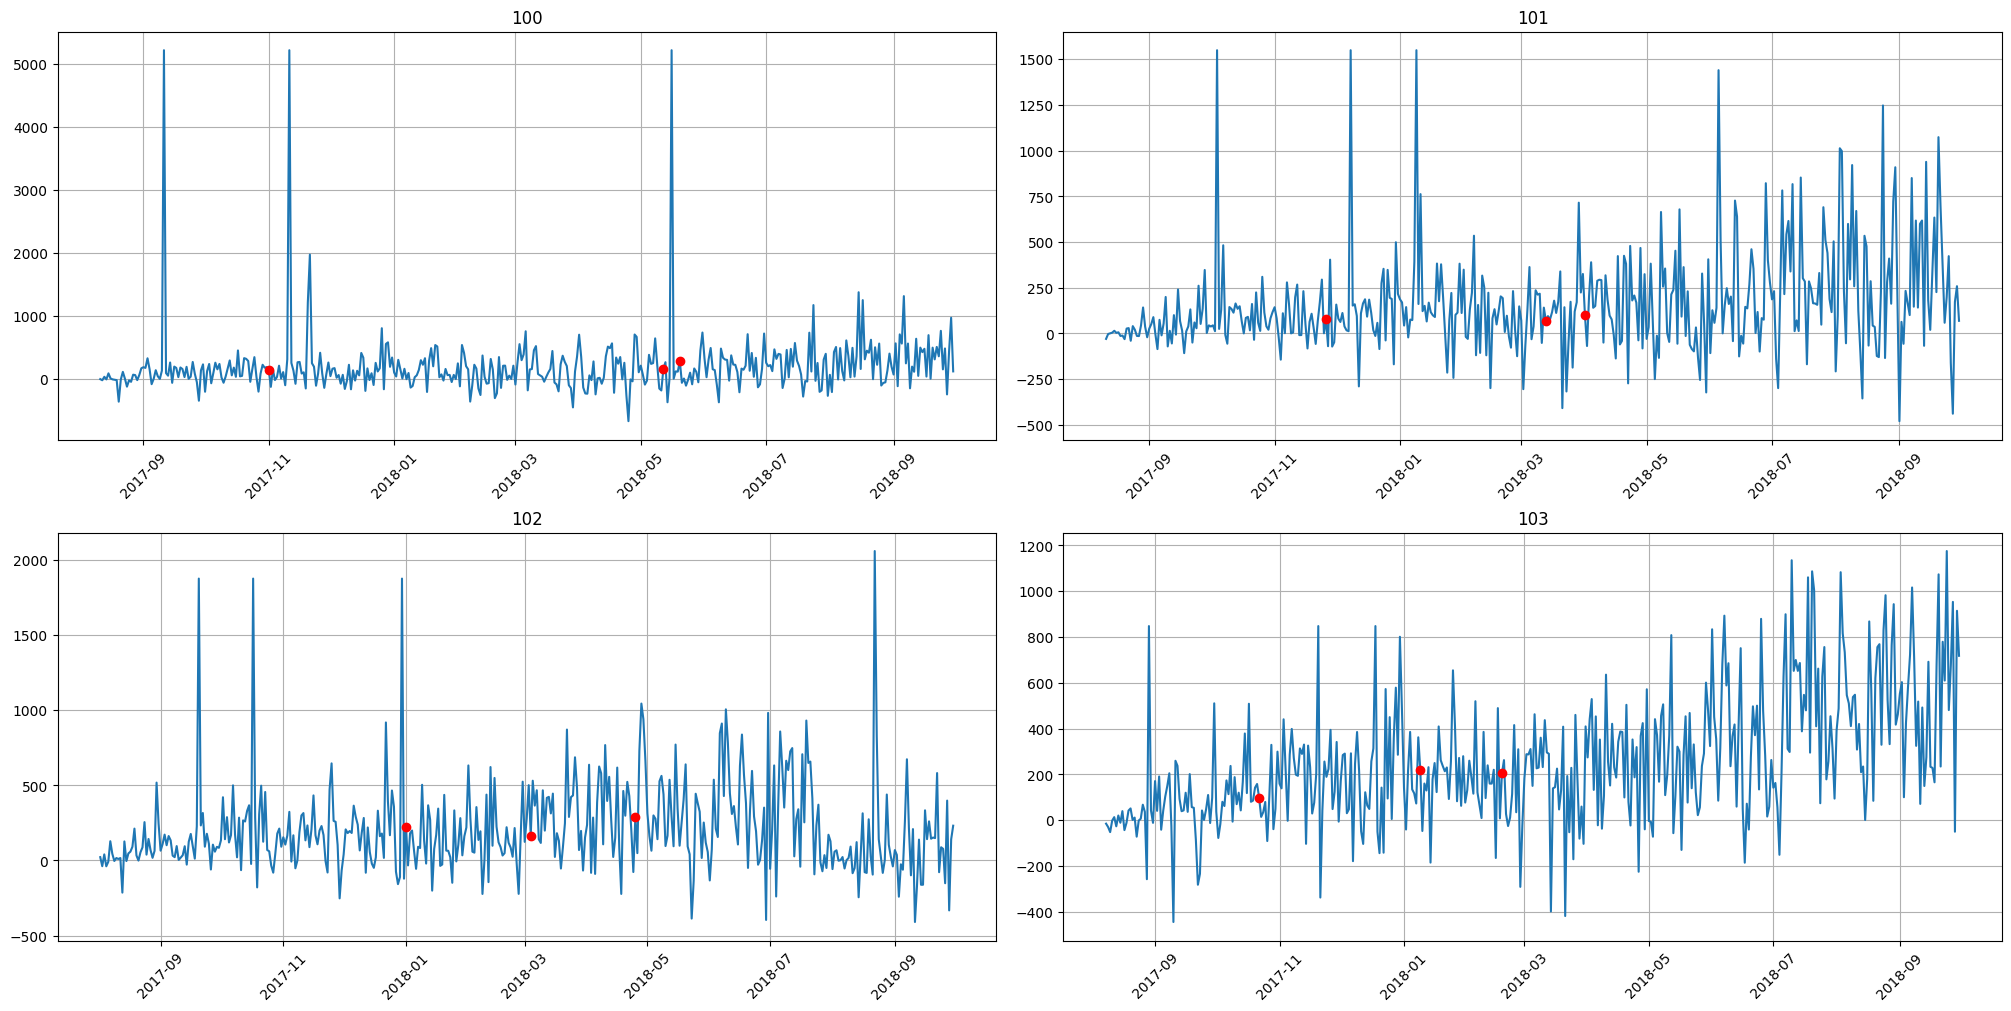

In [ ]:
imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=30)
plot_imputation(ts_filled_nans, imputer, segments=['100', '101', '102', '103'])

In [ ]:
ts_filled_nans.fit_transform([imputer])

In [ ]:
ts_filled_nans.info()

<class 'etna.datasets.TSDataset'>
num_segments: 20
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
100           2017-08-11    2018-09-30     416            0
101           2017-08-11    2018-09-30     416            0
102           2017-08-02    2018-09-30     425            0
103           2017-08-08    2018-09-30     419            0
104           2017-08-07    2018-09-30     420            0
105           2017-07-28    2018-09-30     430            0
106           2017-08-09    2018-09-30     418            0
74            2017-08-16    2018-09-30     411            0
85            2017-08-03    2018-09-30     424            0
86            2017-08-01    2018-09-30     426            0
87            2017-06-09    2018-09-30     479            0
88            2017-08-14    2018-09-30     413            0
90            2017-07-27    2018-09-30     431    

**Проверка рядов на наличие выбросов и их очистка**

In [ ]:
from etna.analysis.outliers import get_anomalies_density
from etna.analysis import plot_anomalies
from etna.transforms import DensityOutliersTransform

В данных нет явных закономерностей и паттернов, поэтому использую метод на основе плотности точек и подбираю гиперпараметры так, чтобы отобрать не только ярко выраженные выбросы, которые визуально легко детектируемы, но и более сложные и менее очевидные выбросы, чтобы уменьшить разброс данных в рядах и сделать данные более структурированными.

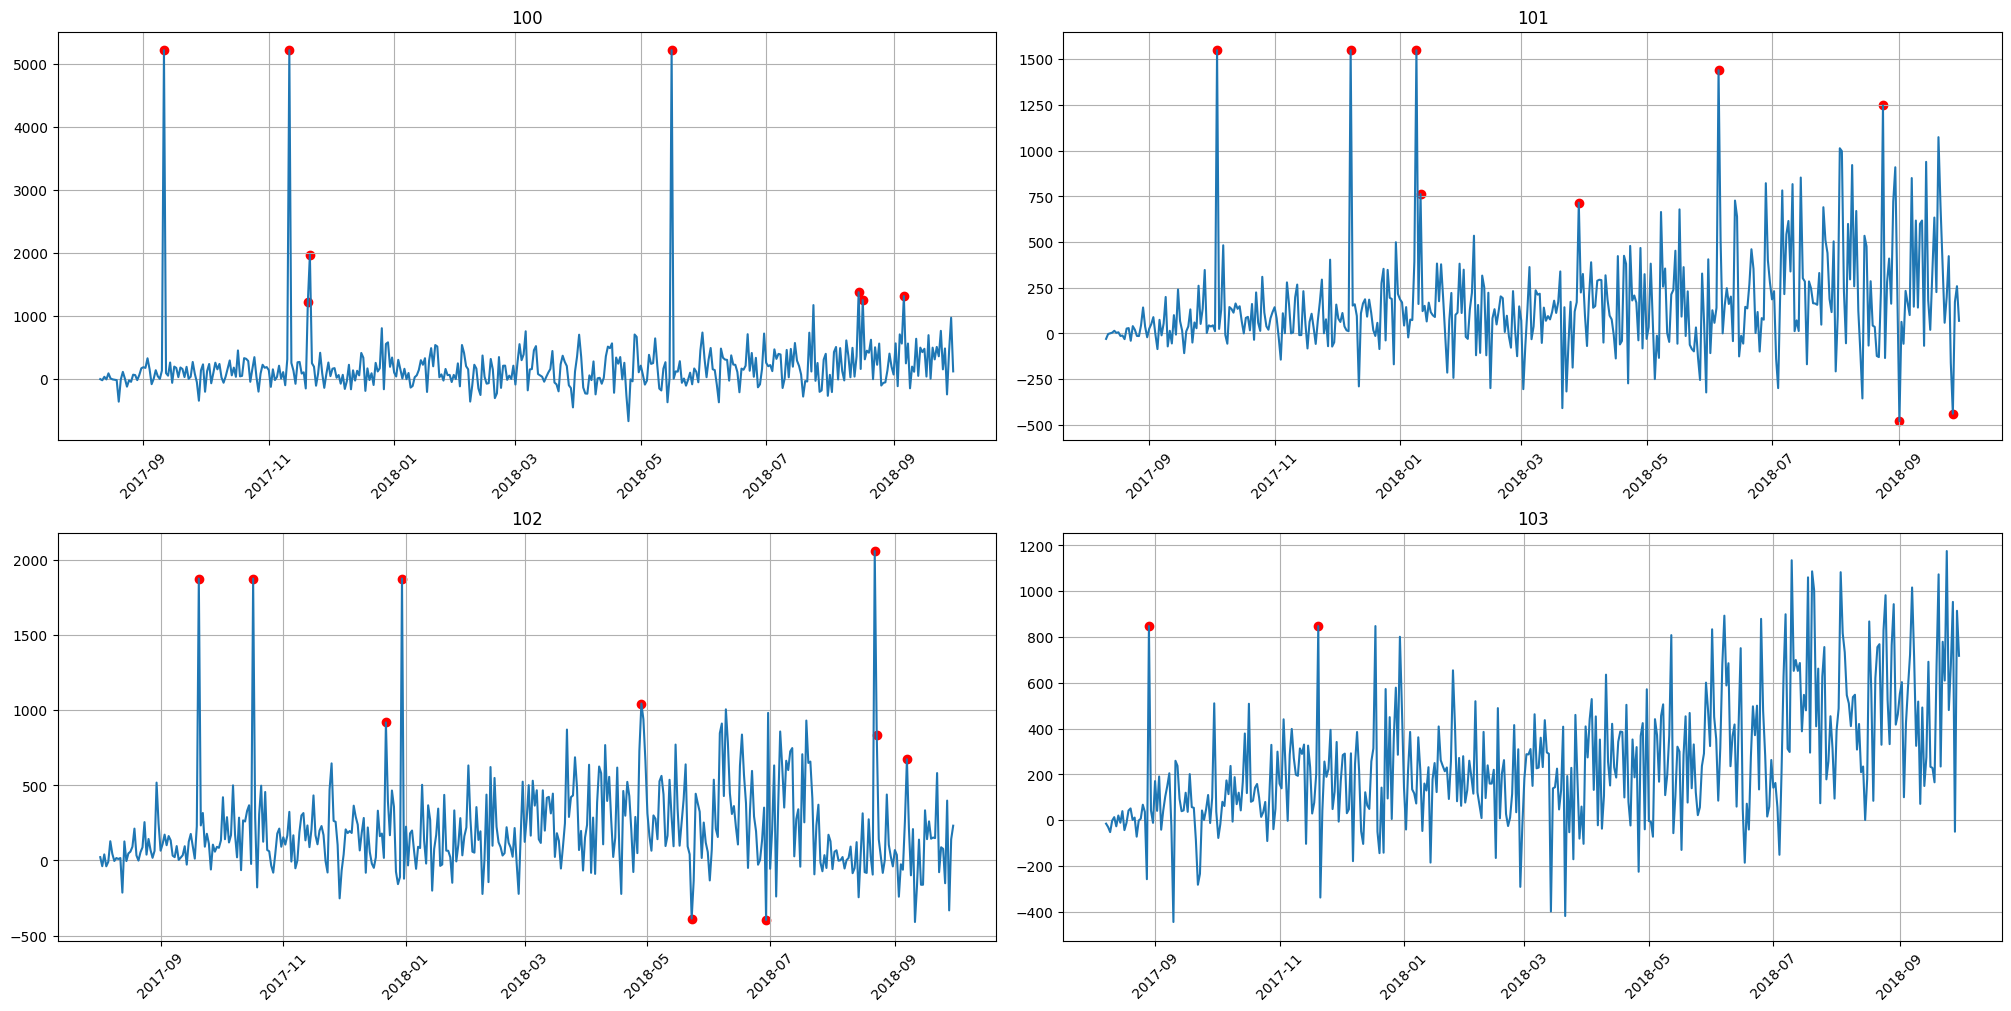

In [ ]:
anomaly_dict = get_anomalies_density(ts_filled_nans, window_size=30, distance_coef=1, n_neighbors=3)
plot_anomalies(ts_filled_nans, anomaly_dict, segments=['100', '101', '102', '103'])

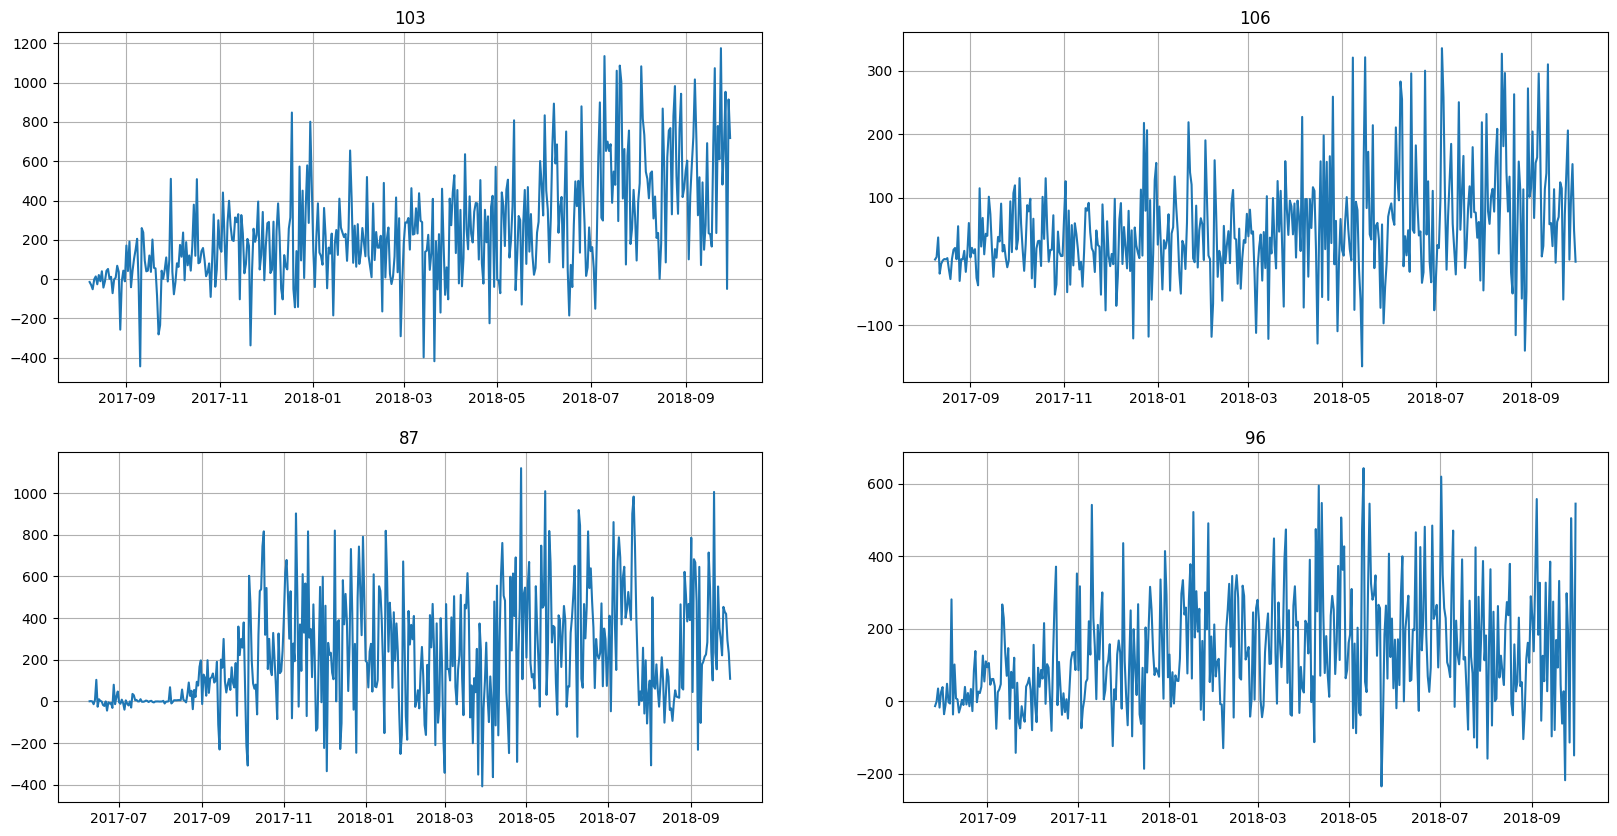

In [ ]:
outliers_remover = DensityOutliersTransform(in_column="target", window_size=30, distance_coef=1, n_neighbors=3)
outliers_imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=30)
ts_filled_nans.fit_transform([outliers_remover, outliers_imputer])
ts_filled_nans.plot(n_segments=4)

#### Построение Prophet

In [ ]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest
from etna.analysis import plot_forecast

In [ ]:
HORIZON = 5 # в качестве горизонта предсказания - 5 дней

In [ ]:
# построение прогнозов при помощи Prophet и etna.Pipeline
# под капотом etna.Pipeline обучит ProphetModel для каждого сегмента в отдельности

train_ts, test_ts = ts_filled_nans.train_test_split(test_size=HORIZON)

prophet_model = ProphetModel()

pipeline_prophet = Pipeline(model=prophet_model, horizon=HORIZON)
pipeline_prophet.fit(train_ts)

forecast_ts = pipeline_prophet.forecast(train_ts)

smape = SMAPE()
metrics = list(smape(y_true=test_ts, y_pred=forecast_ts).values())

# в целях экономии места, выходные данные во многих ячейках с обучением моделей в данном ноутбуке были очищены

In [ ]:
print(sum(metrics)/len(metrics))
forecast_ts.head()

69.93629227933785


segment            100         101         102         103         104  \
feature         target      target      target      target      target   
timestamp                                                                
2018-09-26  160.692737  257.934970  131.694310  483.834479  513.357624   
2018-09-27  198.192596  366.209893  138.925435  482.317725  544.328764   
2018-09-28  248.272721  305.517394  128.219863  571.215869  559.562273   
2018-09-29  330.937332  304.720928  222.115735  611.122051  531.959123   
2018-09-30  349.518696  273.476620  136.839799  456.301778  408.207597   

segment            105         106           74          85          86  \
feature         target      target       target      target      target   
timestamp                                                                 
2018-09-26  413.924424  104.401881  1319.510666  620.374316  206.417222   
2018-09-27  362.211340  119.591339  1485.912085  638.486851  235.608571   
2018-09-28  459.301013  111.469123  1684.537528  728.864034  271.318126   
2018-09-29  296.845755   79.835236  1015.820213  441.824212  128.807038   
2018-09-30  275.171034   87.723401   871.034688  381.306429  138.549910   

segment             87          88          90          91          93  \
feature         target      target      target      target      target   
timestamp                                                                
2018-09-26  293.362784  355.893102  395.813490  140.996904  678.684690   
2018-09-27  295.687612  389.007625  373.377872  178.286626  674.803149   
2018-09-28  404.131870  403.222534  416.721766  146.277336  756.148910   
2018-09-29  368.693397  465.283069  387.955316  231.851497  665.543109   
2018-09-30  336.996157  361.513074  338.055512  179.549594  589.718442   

segment             94          96          97          98          99  
feature         target      target      target      target      target  
timestamp                                                               
2018-09-26  341.376799  188.444259  269.808047  232.024703  158.256594  
2018-09-27  375.472081  198.979731  315.326375  264.002883  232.350328  
2018-09-28  428.615550  195.477120  251.879569  282.573492  289.163847  
2018-09-29  254.835717  161.821847  419.153899  171.072526  340.838714  
2018-09-30  209.388012  110.447323  379.003625  153.908432  211.029045

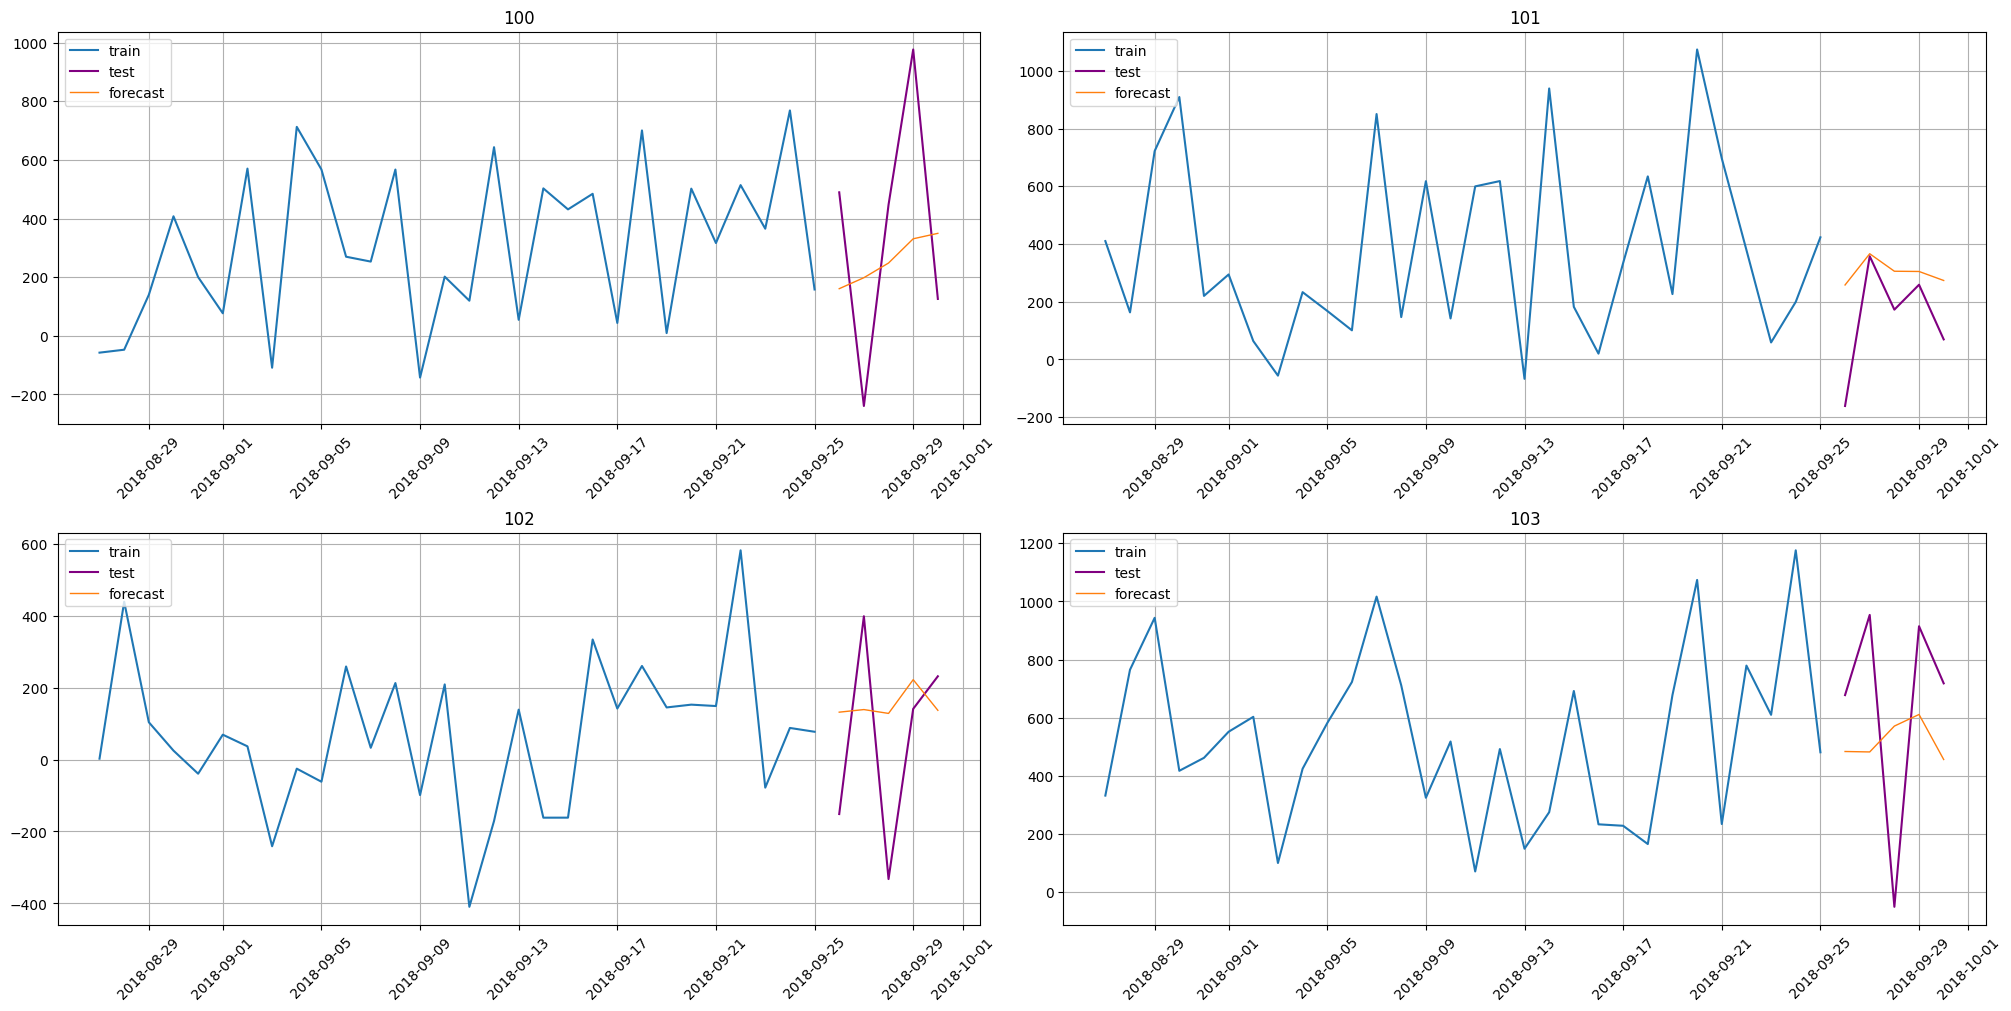

In [ ]:
# отрисовка прогнозов
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=30, segments=['100', '101', '102', '103'])

In [ ]:
# оценка качества по SMAPE на кросс-валидации
metrics_prophet, forecast_prophet, _ = pipeline_prophet.backtest(ts=ts_filled_nans, metrics=[SMAPE()], aggregate_metrics=True)

In [ ]:
print(metrics_prophet['SMAPE'].mean())
metrics_prophet.head()

71.30881360356778


segment      SMAPE
0     100  82.641652
1     101  81.253274
2     102  98.054464
3     103  58.293264
4     104  52.398263

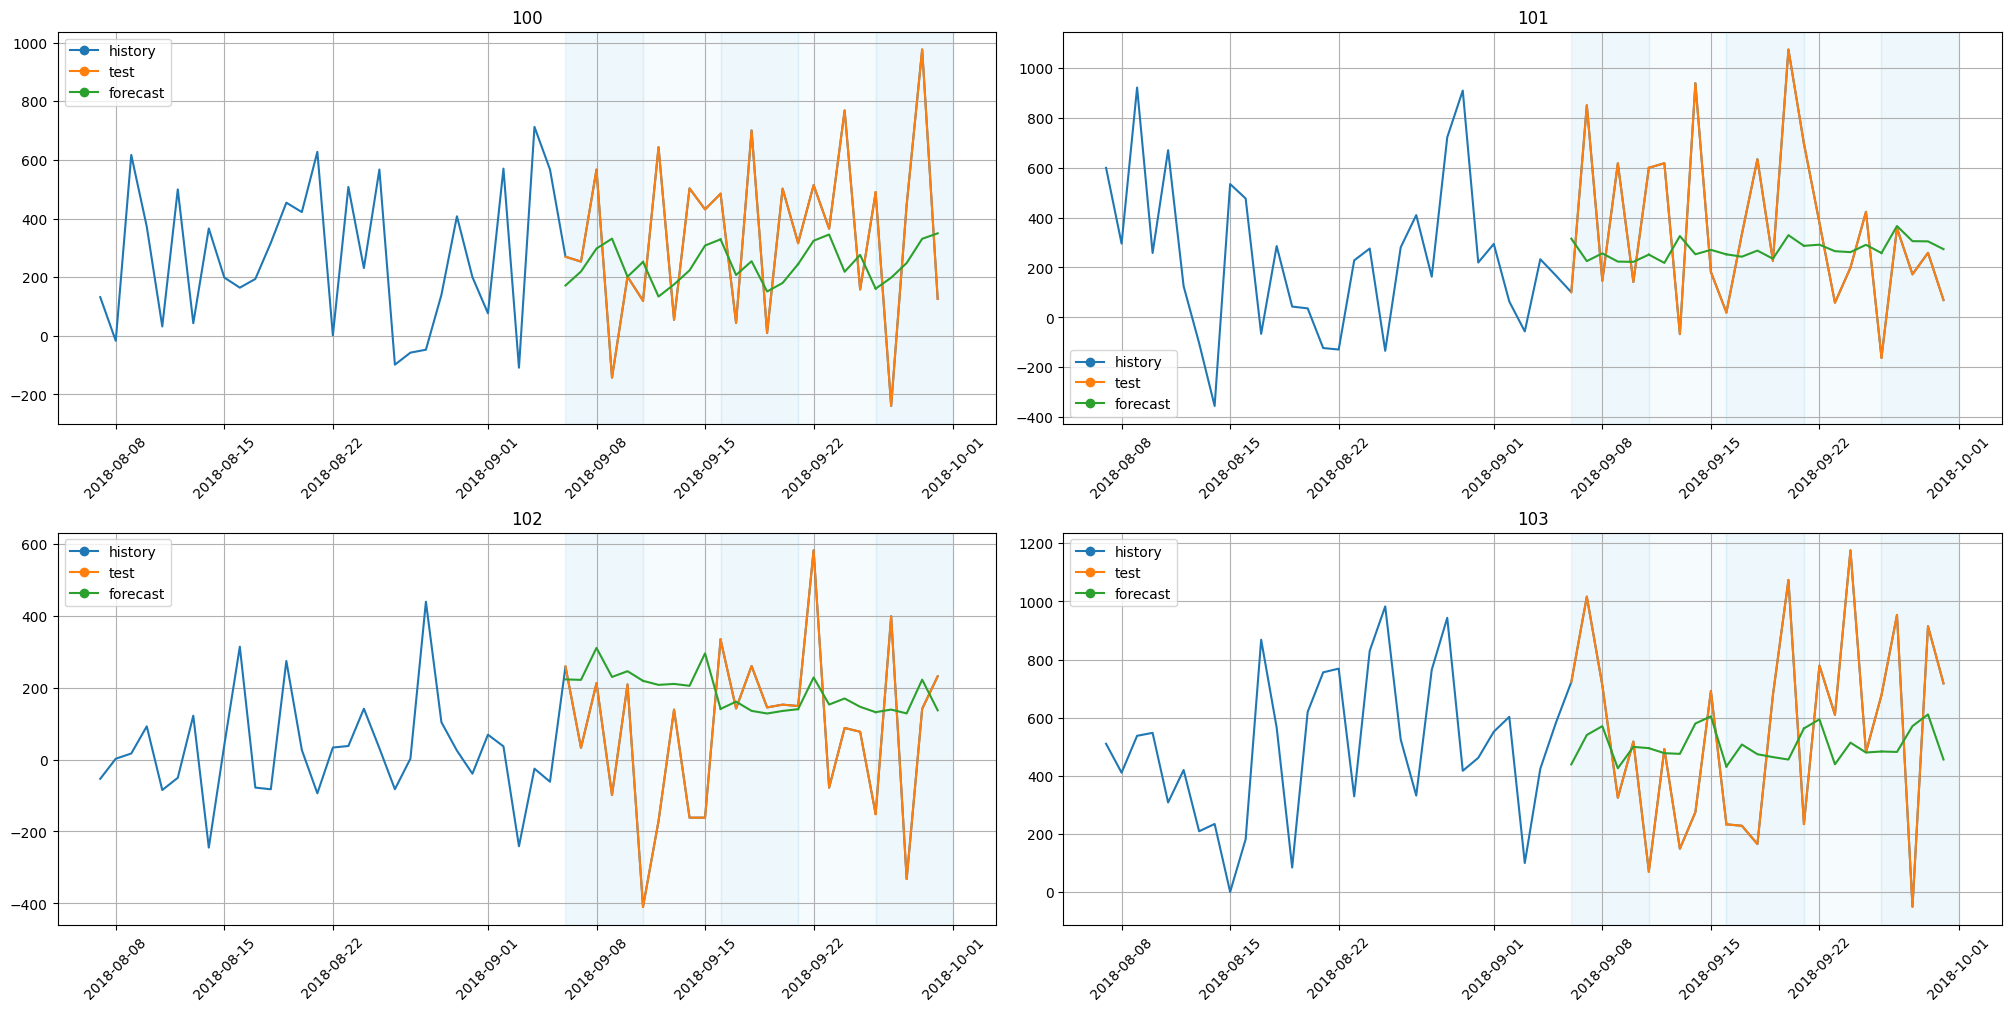

In [ ]:
# отрисовка прогнозов на кросс-валидации
plot_backtest(forecast_prophet, ts_filled_nans, history_len=30, segments=['100', '101', '102', '103'])

# предсказания не очень хорошие, так как модель не смогла уловить величину флуктуаций в данных

In [ ]:
# сравним результаты с кросс-валидацией, проведенной на исходном датасете (без заполненных пропусков и очищенных выбросов)

_, ts = original_tsdataset(df)
metrics_prophet, forecast_prophet, _ = pipeline_prophet.backtest(ts=ts, metrics=[SMAPE()], aggregate_metrics=True)

# работает хуже

In [ ]:
print(metrics_prophet['SMAPE'].mean())
metrics_prophet.head()

75.26246923035848


segment      SMAPE
0     100  84.051400
1     101  86.113112
2     102  97.210831
3     103  58.867757
4     104  53.482043

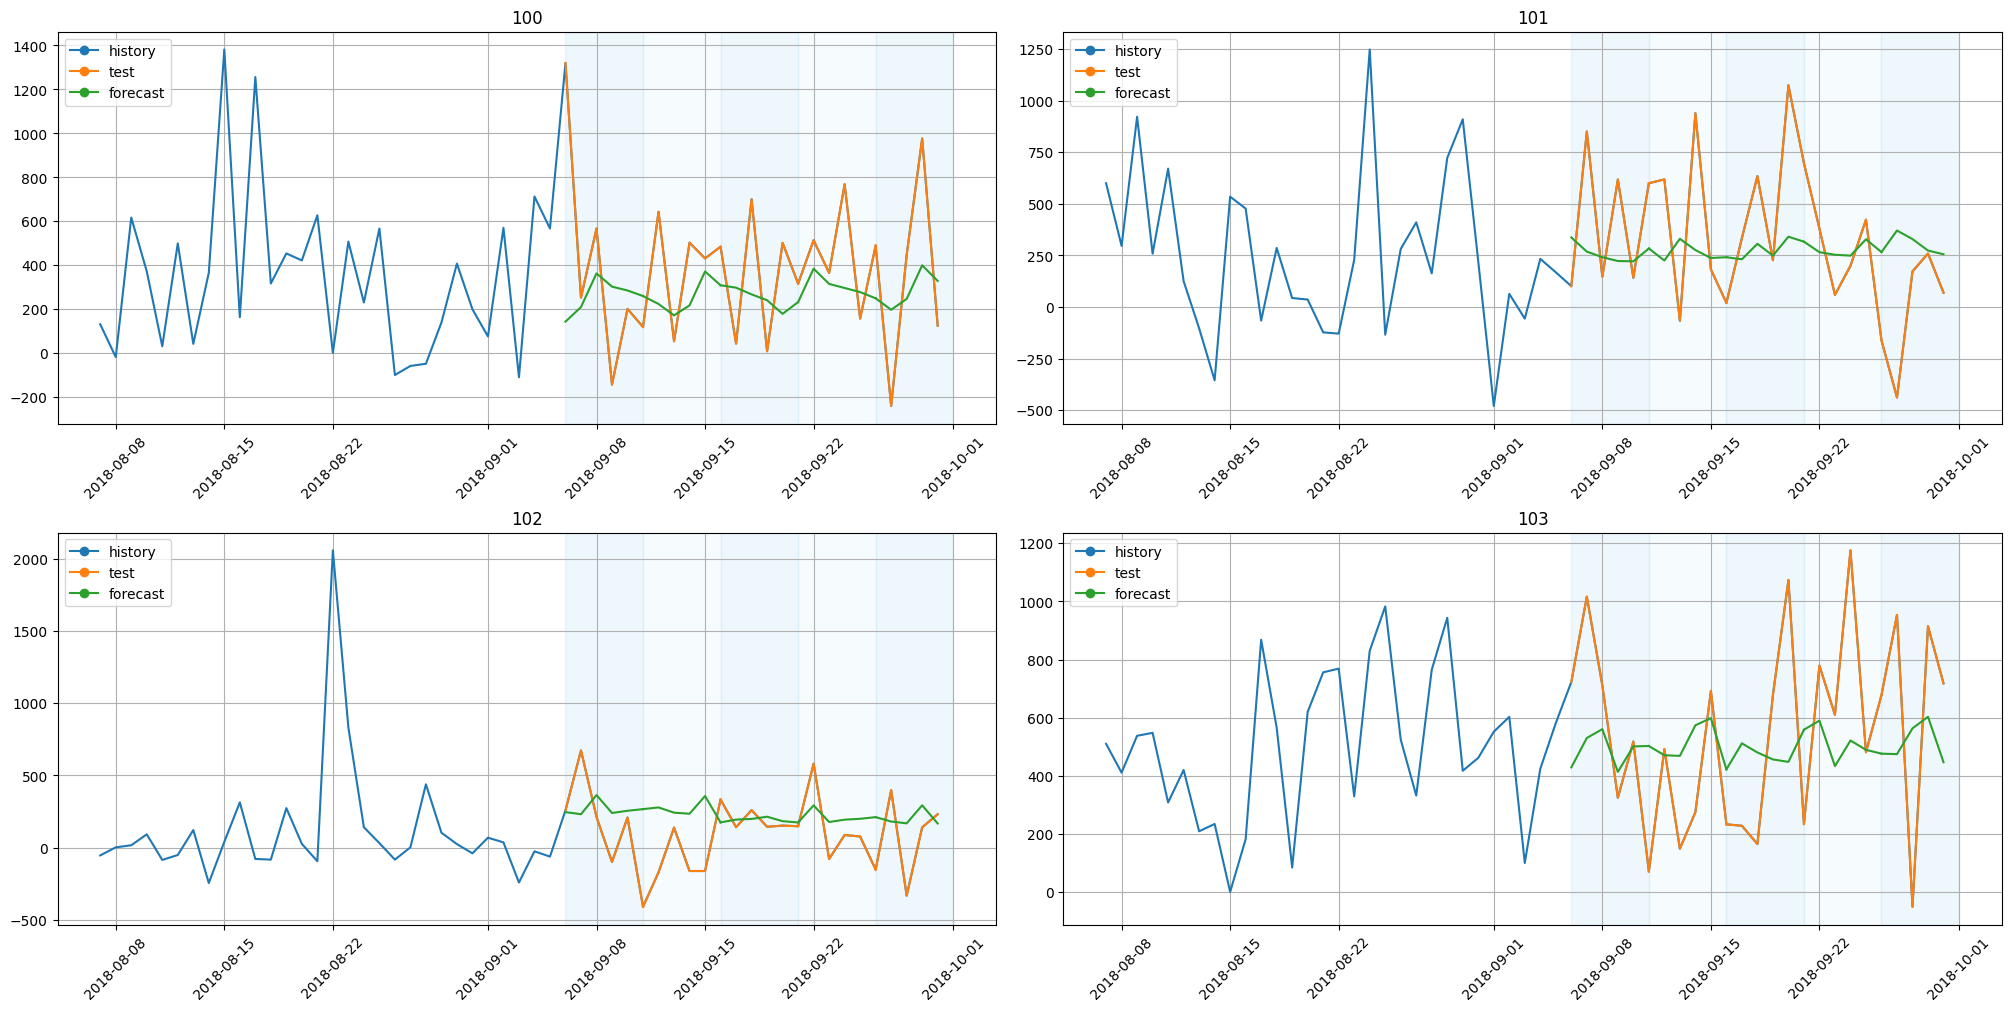

In [ ]:
plot_backtest(forecast_prophet, ts, history_len=30, segments=['100', '101', '102', '103'])

Исходя из статистики по каждому ряду (ряды имеют достаточно большой разброс значений, которые представлены в денежных показателях), можно сделать два вывода:
1. Процентные ошибки использовать лучше.
2. Для предсказания итогового значения лучше использовать иерархию и предсказывать верхний уровень, потому что ряды довольно шумные и хочется использовать какую-то более глобальную инфу о них.

In [ ]:
# то же самое исходя из MAE
metrics_prophet, forecast_prophet, _ = pipeline_prophet.backtest(ts=ts_filled_nans, metrics=[MAE()], aggregate_metrics=True)

In [ ]:
print(metrics_prophet['MAE'].mean())
metrics_prophet.head()

232.13889146739984


segment         MAE
0     100  242.217865
1     101  259.723693
2     102  195.422090
3     103  279.551071
4     104  248.479279

#### Реализация иерархического временного ряда

**Иерархический временной ряд** - ряд, состоящий из других в качестве компонент.

Справочные материалы:
https://github.com/etna-team/etna/blob/master/examples/303-hierarchical_pipeline.ipynb.

In [ ]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import TopDownReconciliator

In [ ]:
original_df = df.copy(deep=True)
original_df['timestamp'] = pd.to_datetime(original_df['datetime'])
original_df['target'] = original_df['operation_value']
original_df['target'] = original_df['target'] + 2000 # чтобы не было отрицательных значений, с которыми не умеет работать TopDownReconciliator
original_df['segment'] = original_df['atm_id'].astype("string")
original_df.drop(columns=['datetime', 'operation_value', 'atm_id'], inplace=True)

# создаю двухуровневую структуру и буду предсказывать для верхнего уровня
hierarchical_structure = HierarchicalStructure(
    level_structure={"total": ['74',  '85',  '86',  '87',  '88',  '90',  '91',  '93',  '94',  '96',  '97', '98',  '99', '100', '101', '102', '103', '104', '105', '106']},
    level_names=["total", "atm_id"]
)

hierarchical_structure

HierarchicalStructure(level_structure = {'total': ['74', '85', '86', '87', '88', '90', '91', '93', '94', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106']}, level_names = ['total', 'atm_id'], )

In [ ]:
# TSDataset с иерархической структурой
hierarchical_ts = TSDataset(df=original_df, freq="D", hierarchical_structure=hierarchical_structure)
hierarchical_ts.head()

segment       100    101    102    103    104    105    106     74     85  \
feature    target target target target target target target target target   
timestamp                                                                   
2017-06-09    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-10    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-11    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-12    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-13    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

segment        86           87     88     90     91     93     94     96  \
feature    target       target target target target target target target   
timestamp                                                                  
2017-06-09    NaN  2000.617780    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-10    NaN  2001.441486    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-11    NaN  1999.764655    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-12    NaN  1986.467683    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-13    NaN  2007.398647    NaN    NaN    NaN    NaN    NaN    NaN   

segment        97     98     99  
feature    target target target  
timestamp                        
2017-06-09    NaN    NaN    NaN  
2017-06-10    NaN    NaN    NaN  
2017-06-11    NaN    NaN    NaN  
2017-06-12    NaN    NaN    NaN  
2017-06-13    NaN    NaN    NaN

In [ ]:
hierarchical_ts.current_df_level

'atm_id'

In [ ]:
# реконсилятор, который позволит собирать искомый ряд из составных компонент
ahp_reconciliator = TopDownReconciliator(
    target_level="atm_id", source_level="total", method="AHP", period=30
)

In [ ]:
ahp_reconciliator.fit(ts=hierarchical_ts)
ahp_reconciliator.mapping_matrix.toarray()

array([[0.07003209],
       [0.05223599],
       [0.04633929],
       [0.05109391],
       [0.05013669],
       [0.05125499],
       [0.04665721],
       [0.05684448],
       [0.04938839],
       [0.04502354],
       [0.04834178],
       [0.04755604],
       [0.04821156],
       [0.04945662],
       [0.04704388],
       [0.04329304],
       [0.05276966],
       [0.05222584],
       [0.04850755],
       [0.04358745]])

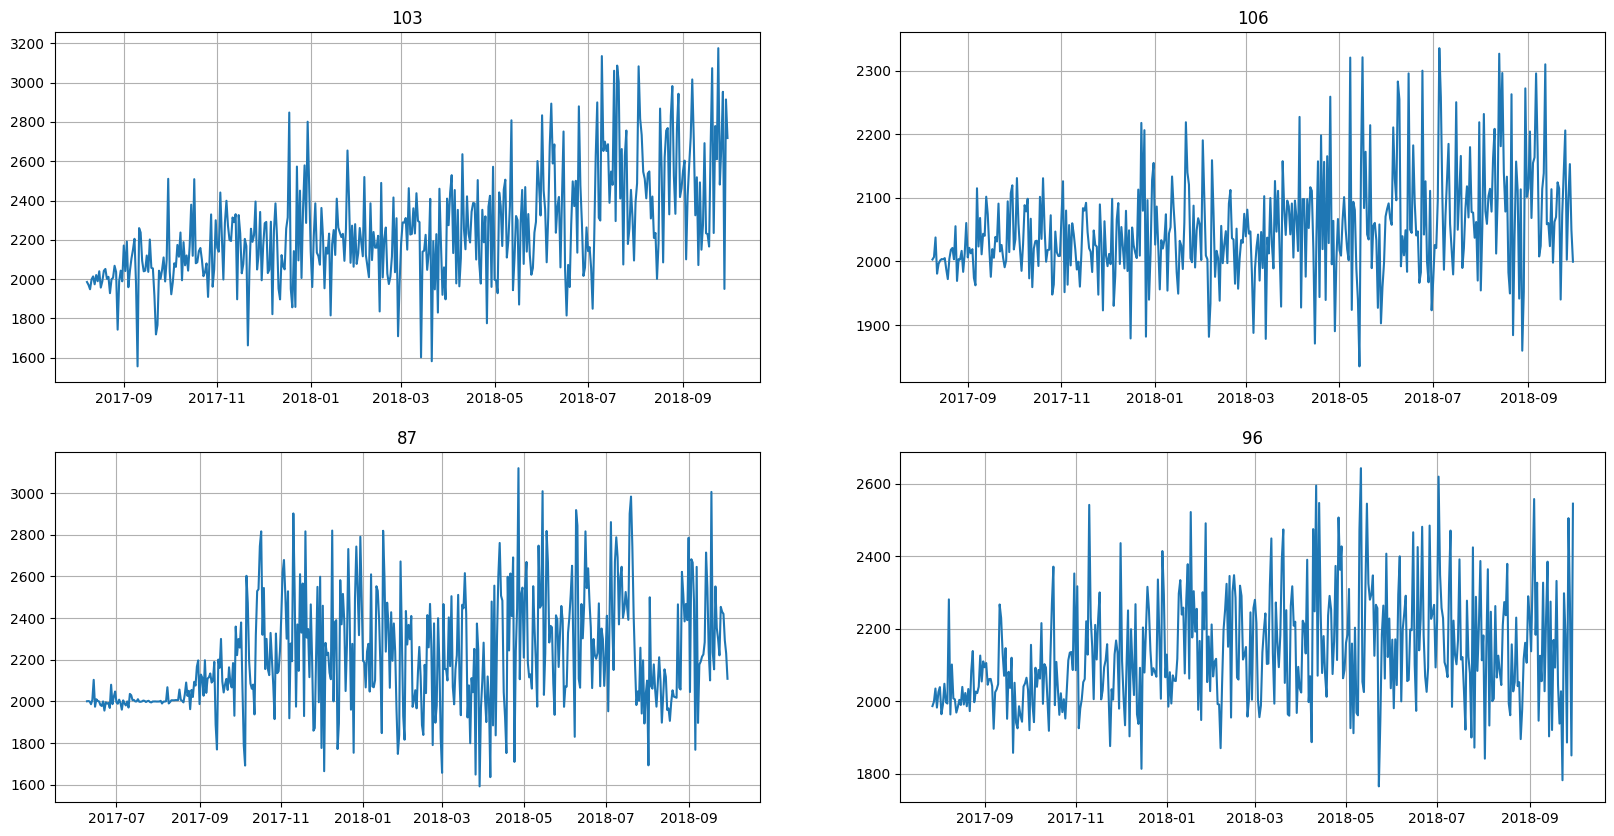

In [ ]:
# заполнение пропусков
imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=30)
hierarchical_ts.fit_transform([imputer])
# очистка от выбросов
outliers_remover = DensityOutliersTransform(in_column="target", window_size=30, distance_coef=1, n_neighbors=3)
outliers_imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=30)
hierarchical_ts.fit_transform([outliers_remover, outliers_imputer])
hierarchical_ts.plot(n_segments=4)

In [ ]:
# Prophet с MAE на кросс-валидации
prophet_model = ProphetModel()

pipeline = HierarchicalPipeline(
    transforms=[],
    model=prophet_model,
    reconciliator=ahp_reconciliator,
    horizon=HORIZON,
)

ahp_metrics, _, _ = pipeline.backtest(ts=hierarchical_ts, metrics=[MAE()], aggregate_metrics=True)
ahp_metrics = ahp_metrics.set_index("segment").add_suffix("_ahp")

In [ ]:
print(ahp_metrics['MAE_ahp'].mean())
ahp_metrics.head()

242.54027026982567


MAE_ahp
segment            
100      240.558793
101      259.374216
102      193.651712
103      295.599043
104      249.217611

In [ ]:
# другой метод реконсилиации
pha_reconciliator = TopDownReconciliator(target_level="atm_id", source_level="total", method="PHA", period=30)

pipeline = HierarchicalPipeline(
    transforms=[],
    model=prophet_model,
    reconciliator=pha_reconciliator,
    horizon=HORIZON,
)

pha_metrics, _, _ = pipeline.backtest(ts=hierarchical_ts, metrics=[MAE()], aggregate_metrics=True)
pha_metrics = pha_metrics.set_index("segment").add_suffix("_pha")

# стало совсем немного хуже

In [ ]:
print(pha_metrics['MAE_pha'].mean())
pha_metrics.head()

242.60033154705314


MAE_pha
segment            
100      240.573750
101      259.793769
102      194.949647
103      295.650198
104      248.825545

In [ ]:
# сравним с результатом, полученным для нижнего уровня сразу
atm_id_level_ts = hierarchical_ts.get_level_dataset(target_level="atm_id")

pipeline = Pipeline(
    transforms=[],
    model=prophet_model,
    horizon=HORIZON,
)

atm_id_level_metrics, _, _ = pipeline.backtest(ts=atm_id_level_ts, metrics=[MAE()], aggregate_metrics=True)

atm_id_level_metrics = atm_id_level_metrics.set_index("segment").add_suffix("_atm_id_level")

# все-таки лучше предсказывать сразу для каждого сегмента, а не на общем уровне

In [ ]:
print(atm_id_level_metrics['MAE_atm_id_level'].mean())
atm_id_level_metrics.head()

231.77696292476148


MAE_atm_id_level
segment                  
100            236.245799
101            266.374962
102            193.148482
103            274.360798
104            243.633806

#### Построение признаков

Теперь поработаем с исходным мультисегментным рядом и моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества.

In [ ]:
from etna.analysis import acf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostPerSegmentModel, AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform, HolidayTransform, DateFlagsTransform, MeanTransform, StdTransform

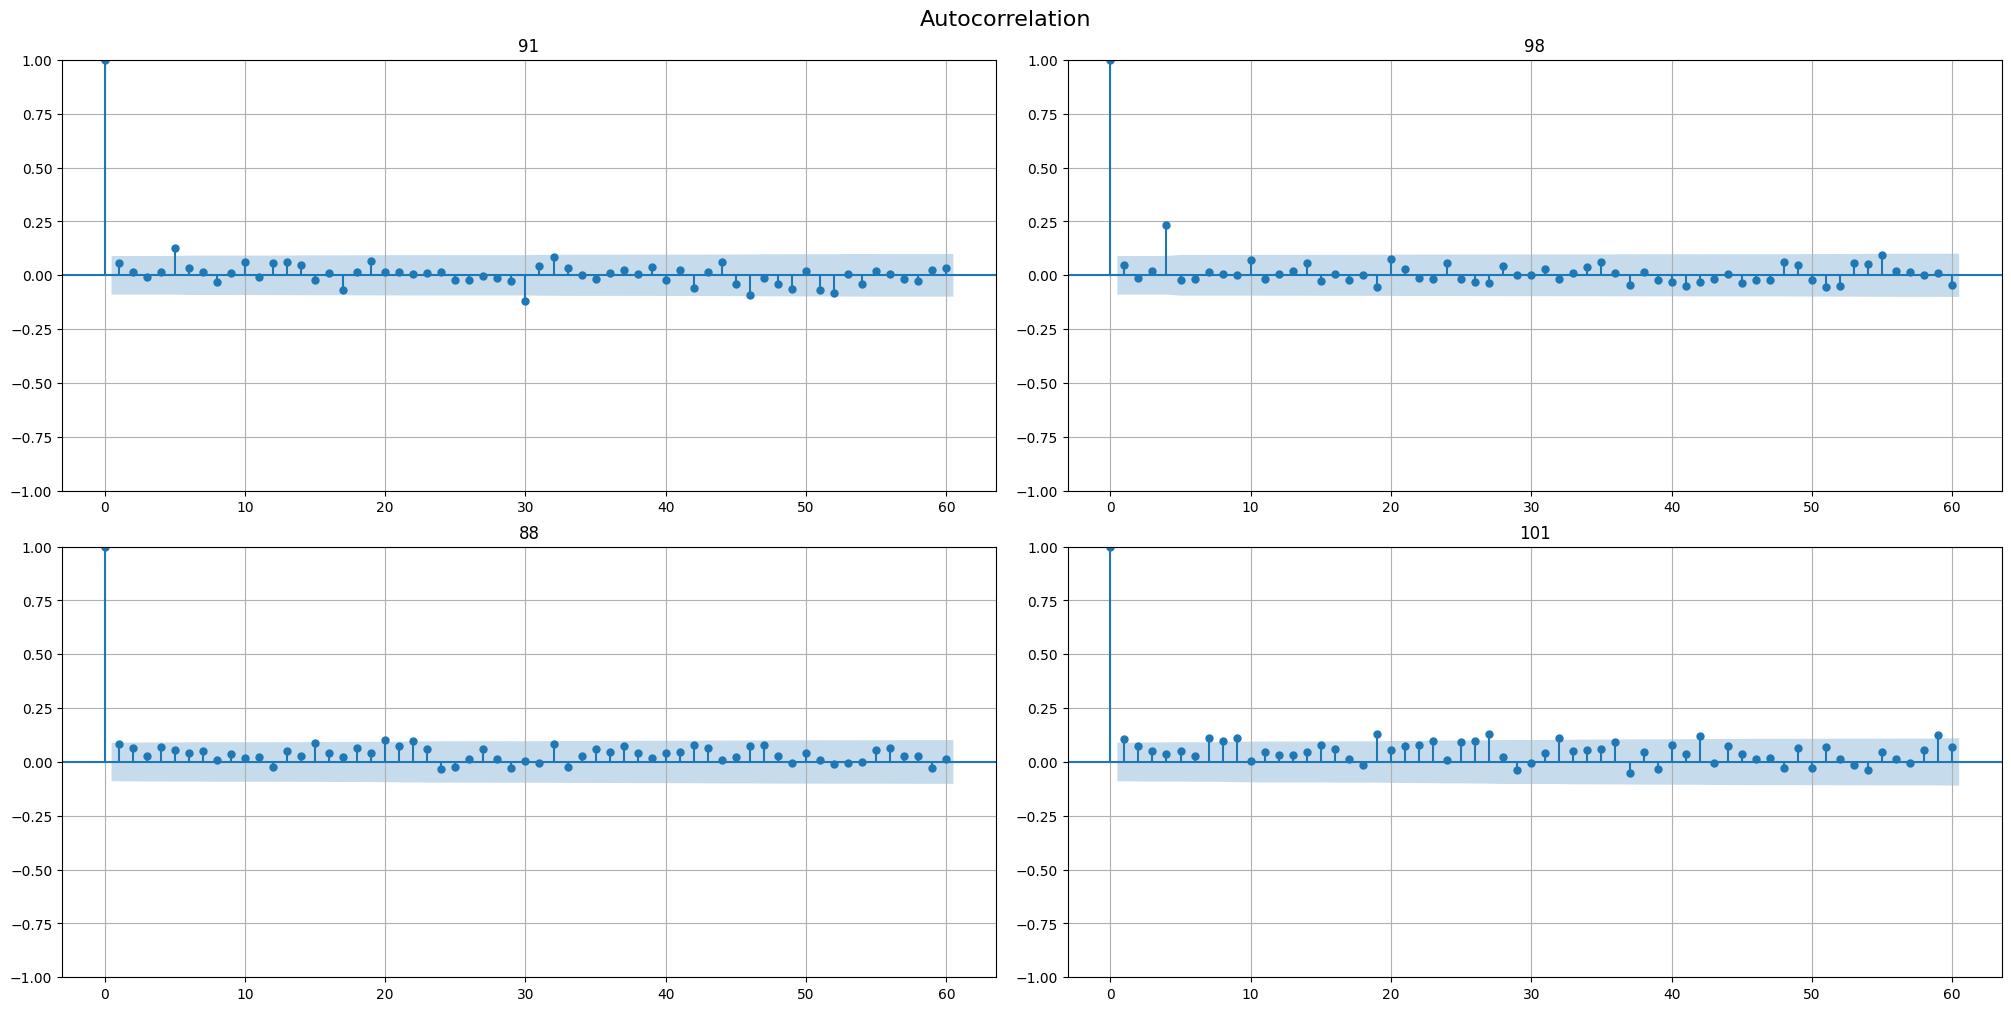

In [ ]:
# построение графиков автокорреляции и обоснование при помощи них выбора лаговых признаков
_, ts = original_tsdataset(df)
acf_plot(ts, lags=60, n_segments=4)

- Для некоторых сегментов (91, 100, 96, 101, 88) значения не выходят (или выходят совсем немного) за пределы синего окна - корреляции слабые.
- Для 85 сегмента наблюдаются корреляции с каждым 7 лагом, поэтому возьму 7, 14 и 28 лаги.
- Для некоторых сегментов можно выделить один или несколько лагов, возвышающихся над другими:

| сегмент | лаги      |
|---------|-----------|
| 74      | 7         |
| 102     | 1         |
| 98      | 4         |
| 105     | 7, 27, 34 |
| 97      | 7         |
| 94      | 14, 21, 28|
| 106     | 6, 56     |
| 99      | 21        |
| 86      | 1         |

- А есть сегменты, для которых наблюдается корреляция с большинством лагов, но для таких сегментов можно увидеть следующий паттерн: сначала корреляции растут (не всегда монотонно), но на определенном лаге достигают наибольшего значения, и после уже меньше скоррелированы с текущим лагом. Отметим такие сегменты: в 103 сегменте - первые 7 лагов, в 90 - первые 9 лагов и отдельно 23 лаг, в 104 - первые 13 лагов, в 93 - первые 7 лагов, в 87 - первые 7 лагов.

Объединяя все вышесказанное, я взяла первые 14 лагов и отдельно 21, 23, 27, 28, 34, 56 лаги, чтобы учесть в одной модели все важные лаги для всех сегментов сразу.

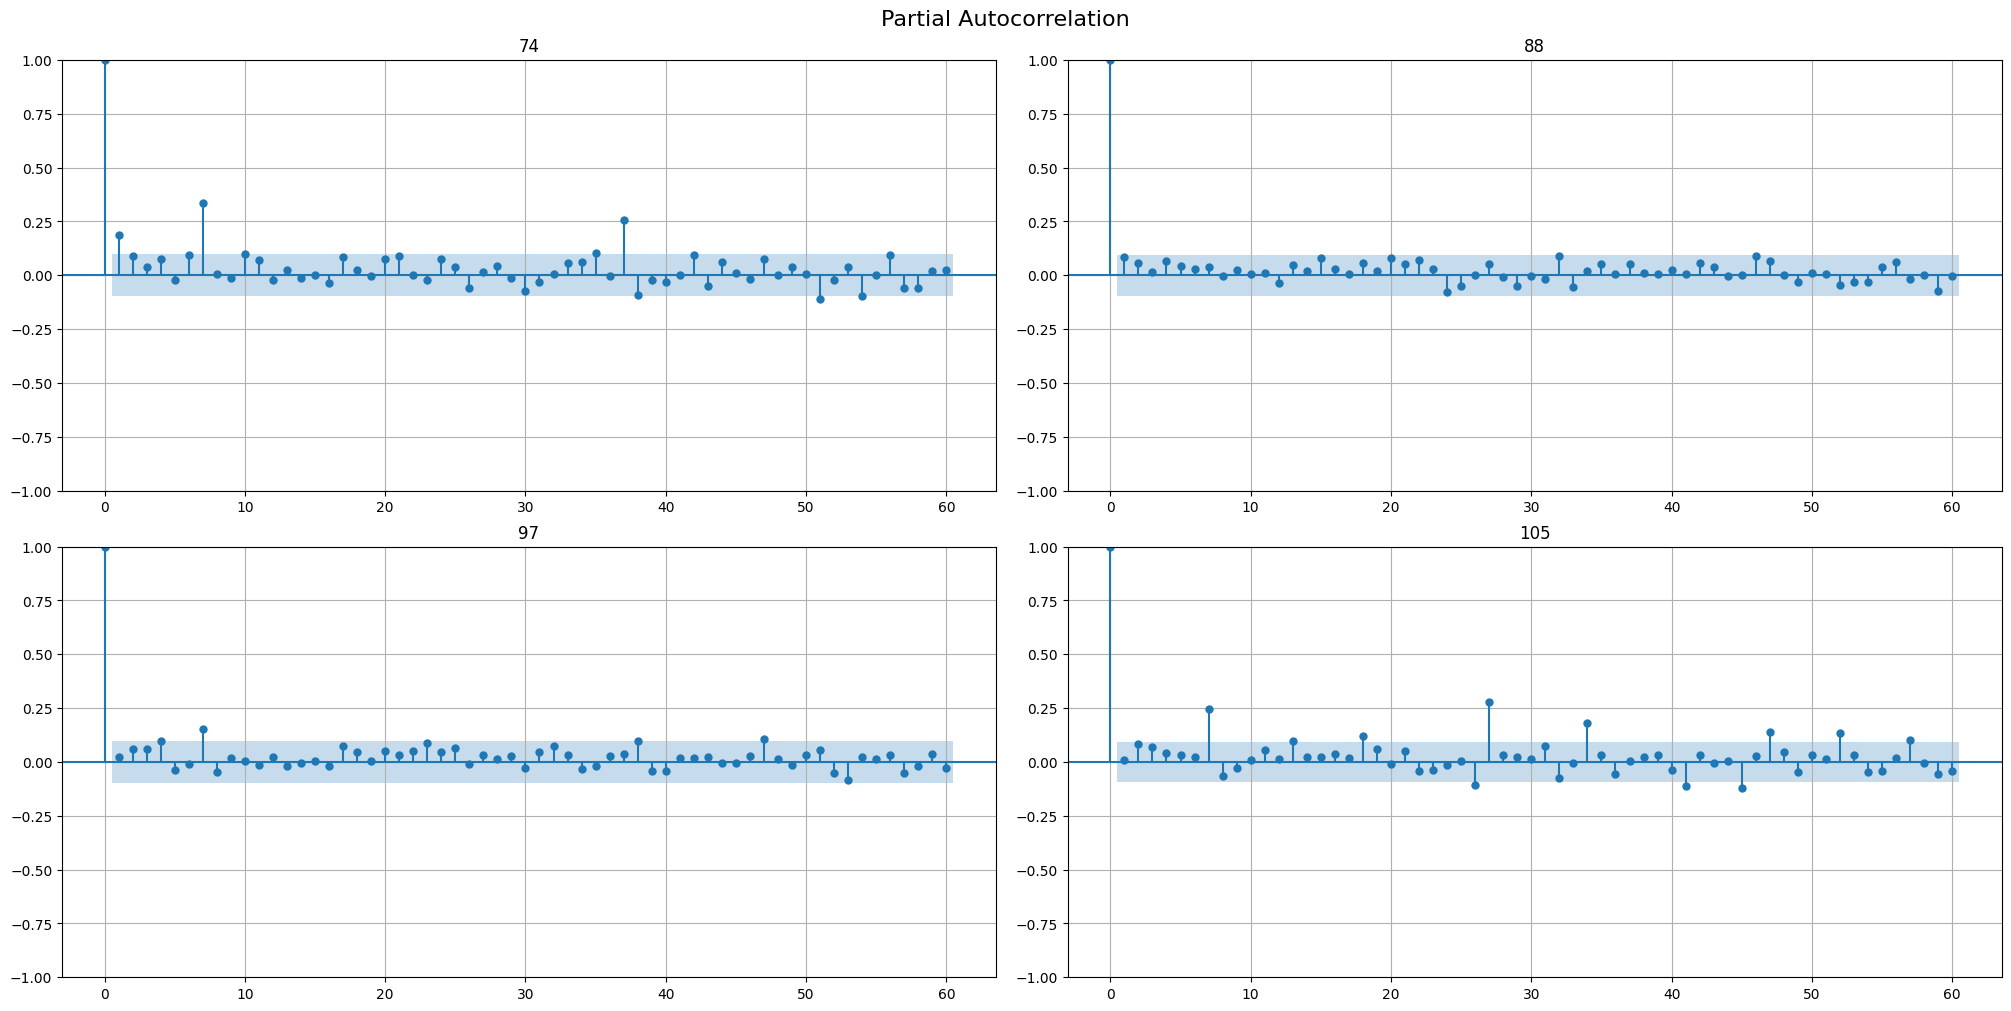

In [ ]:
# частичная автокорреляция не строится для рядов с пропусками внутри, поэтому сначала заполним их
imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=30)
ts.fit_transform([imputer])
acf_plot(ts, lags=60, n_segments=4, partial=True)

Здесь та же логика рассуждения. К предыдущим выбранным лагам добавляются еще 25 (96 сегмент), 37 (96 и 74 сегменты), 47 (96 сегмент), 59 (94 сегмент) и 60 (86 сегмент) лаги.

In [ ]:
# здесь использую обычный пайплайн, который использует прямую стратегию, поэтому лаги беру начиная с 5-го (особенность, которую прямая стратегии накладывает на признаки)
lags = list(range(5, 15, 1)) + list(range(21, 28, 2)) + list([28, 34, 37, 47, 56, 59, 60])
lags = LagTransform(in_column="target", lags=lags, out_column="target_lag")

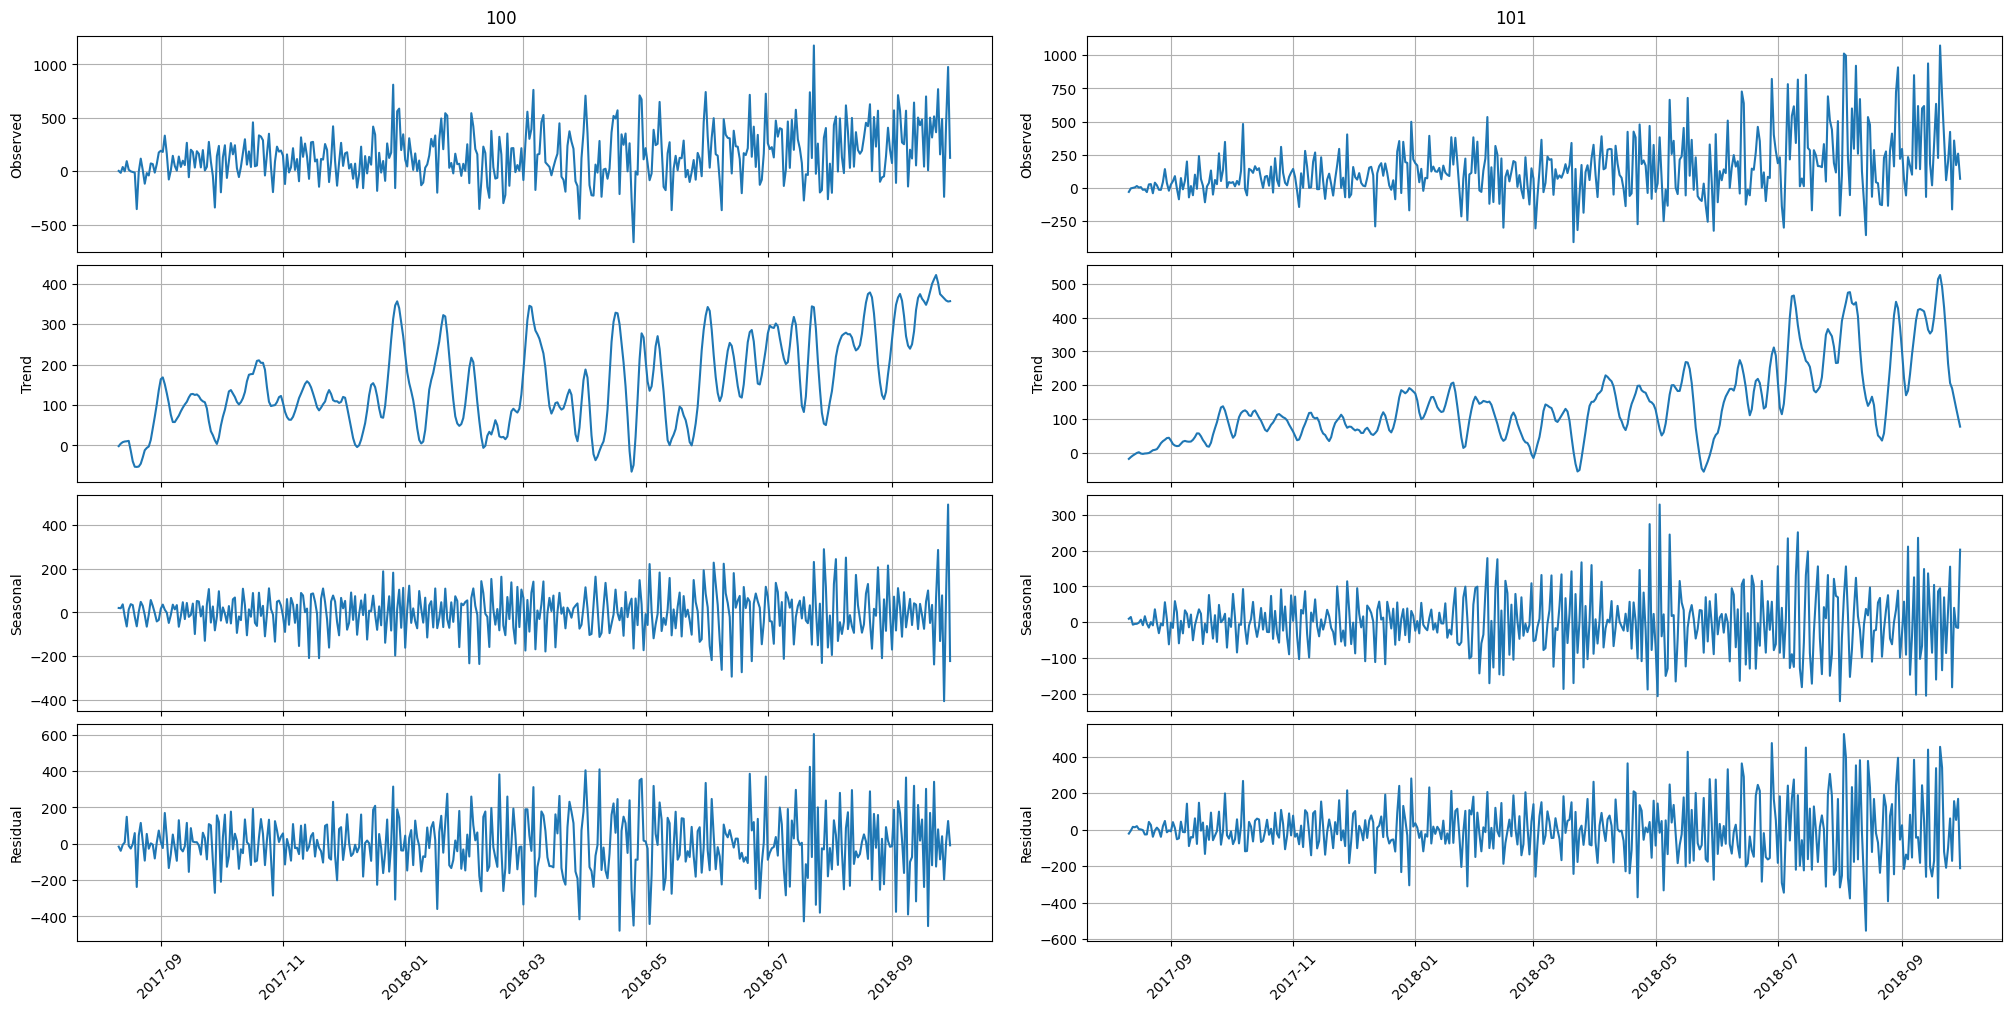

In [ ]:
# для катбуста включу в признаки результаты STL разложения (используется для убирания тренда за счет преобразования на месте)
stl_plot(ts=ts_filled_nans, period=5, segments=['100', '101'])

# тренд при таком значении периода выглядит не очень, но я выбрала это значение, так как оно показывало лучшие метрики при обучении CatBoost дальше

In [ ]:
stl_transforms = STLTransform(in_column="target", period=5, model='holt')

**Какие еще закономерности могут присутствовать в данных:**

1) цикличность (колебания на более длительных временных периодах, чем сезонность), связанная, например, с экономическими циклами

2) изменения в данных, связанные с кризисами, политическими событиями или другими событиями (например, пандемией)

3) изменения в данных из-за структурных изменений в экономике, законодательстве или технологиях

4) туристические сезоны (в регионах с высоким уровнем туризма в туристические сезоны больше туристов)

Первые четыре вида закономерностей предсказать сложно, так как они имеют сложную, непостоянную природу, которая вызвана внешними факторами и событиями, поэтому для их предсказания нужны доп данные.

5) закономерности, связанные с временем года (летом люди уезжают с семьей на отдых)

6) выходные и праздничные сезоны (люди тратят больше денег на подарки, путешествия и развлечения)

7) экономические факторы (начало нового финансового года, выплаты з/п и пособий)

Последние три закономерности легко учесть при помощи библиотеки ETNA.

In [ ]:
# сделаем соответствующие признаки
seg = SegmentEncoderTransform() # преобразуем метки сегментов в категориальные переменные

# учтем признаки на основе даты
d_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    season_number=True, # учтем время года
    is_weekend=True, # учтем выходные
    special_days_in_month=[15, 30], # учтем дни выплаты з/п
    out_column="date_flag",
)

holidays = HolidayTransform(out_column="holidays") # учтем праздничные дни
# лаги для праздников, так как перед праздниками люди тоже могут тратить больше денег
holidays_lags = LagTransform(in_column="holidays", lags=list(range(1, 7)), out_column="holidays_lag")

# стат признаки
mean30 = MeanTransform(in_column="target", window=30, out_column="target_mean")
std30 = StdTransform(in_column="target", window=30, out_column="target_std")

**Обучение на получившихся признаках моделей**

In [ ]:
arima_model = AutoARIMAModel()
transforms = [lags, seg, d_flags, holidays, holidays_lags, mean30, std30]

pipeline_arima = Pipeline(model=arima_model, transforms=transforms, horizon=HORIZON)

metrics_arima, forecast_arima, _ = pipeline_arima.backtest(ts=ts_filled_nans, metrics=[SMAPE(), MAE()], aggregate_metrics=True)
print(metrics_arima[['SMAPE', 'MAE']].mean())
metrics_arima.head()

# Prophet показывает лучшие метрики

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  2.4min
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  4.7min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  6.9min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  9.3min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed: 11.6min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed: 11.6min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   13.3s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   17.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   21.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   21.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Do

SMAPE     79.786782
MAE      248.480840
dtype: float64


segment       SMAPE         MAE
0     100   79.776461  229.103113
1     101   86.256927  278.510950
2     102  123.771574  194.735153
3     103   55.519599  265.716139
4     104   53.196007  266.671796

In [ ]:
# для CatBoost рассмотрим 2 версии - мультисегментную и на каждый ряд в отдельности
catboost_multi_model = CatBoostMultiSegmentModel()
transforms = [lags, seg, d_flags, holidays, holidays_lags, mean30, std30]

pipeline_catboost_multi = Pipeline(model=catboost_multi_model, transforms=transforms, horizon=HORIZON)

metrics_catboost_multi, forecast_catboost_multi, _ = pipeline_catboost_multi.backtest(ts=ts_filled_nans, metrics=[SMAPE(), MAE()], aggregate_metrics=True)
print(metrics_catboost_multi[['SMAPE', 'MAE']].mean())
metrics_catboost_multi.head()

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   20.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   42.9s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Do

SMAPE     73.927230
MAE      253.498995
dtype: float64


segment       SMAPE         MAE
0     100   80.429217  275.118803
1     101   82.990407  282.537342
2     102  104.436569  221.462870
3     103   58.045496  285.631301
4     104   55.702296  270.671505

In [ ]:
catboost_multi_model = CatBoostMultiSegmentModel()
transforms = [lags, stl_transforms, seg, d_flags, holidays, holidays_lags, mean30, std30]

pipeline_catboost_multi = Pipeline(model=catboost_multi_model, transforms=transforms, horizon=HORIZON)

metrics_catboost_multi, forecast_catboost_multi, _ = pipeline_catboost_multi.backtest(ts=ts_filled_nans, metrics=[SMAPE(), MAE()], aggregate_metrics=True)
print(metrics_catboost_multi[['SMAPE', 'MAE']].mean())
metrics_catboost_multi.head()

# сколько бы я ни пыталась подобрать период в STLTransform, улучшить метрики так и не удалось
# в итоге, без STLTransform CatBoost работает лучше, но все еще хуже, чем Prophet

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   26.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   52.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   11.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   17.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   23.6s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   28.8s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   28.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Do

SMAPE     81.999207
MAE      287.379201
dtype: float64


segment       SMAPE         MAE
0     100   82.615813  292.252469
1     101   78.027309  277.376064
2     102  100.781477  253.966057
3     103   64.710657  309.857635
4     104   70.929125  298.060528

In [ ]:
catboost_perseg_model = CatBoostPerSegmentModel()
transforms = [lags, seg, d_flags, holidays, holidays_lags, mean30, std30]

pipeline_catboost_perseg = Pipeline(model=catboost_perseg_model, transforms=transforms, horizon=HORIZON)

metrics_catboost_perseg, forecast_catboost_perseg, _ = pipeline_catboost_perseg.backtest(ts=ts_filled_nans, metrics=[SMAPE(), MAE()], aggregate_metrics=True)
print(metrics_catboost_perseg[['SMAPE', 'MAE']].mean())
metrics_catboost_perseg.head()

# SMAPE немного хуже, чем для CatBoostMultiSegmentModel, но зато MAE немного лучше (все еще хуже, чем Prophet)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  7.8min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 11.2min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed: 14.5min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed: 17.8min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed: 17.8min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Do

SMAPE     74.993786
MAE      246.068914
dtype: float64


segment       SMAPE         MAE
0     100   80.640376  239.773315
1     101   87.567744  293.022821
2     102  105.158112  197.543884
3     103   62.566918  302.082675
4     104   52.845491  251.944305

In [ ]:
catboost_perseg_model = CatBoostPerSegmentModel()
transforms = [lags, stl_transforms, seg, d_flags, holidays, holidays_lags, mean30, std30]

pipeline_catboost_perseg = Pipeline(model=catboost_perseg_model, transforms=transforms, horizon=HORIZON)

metrics_catboost_perseg, forecast_catboost_perseg, _ = pipeline_catboost_perseg.backtest(ts=ts_filled_nans, metrics=[SMAPE(), MAE()], aggregate_metrics=True)
print(metrics_catboost_perseg[['SMAPE', 'MAE']].mean())
metrics_catboost_perseg.head()

# аналогичная ситуация

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  3.4min
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  7.1min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 11.0min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed: 14.5min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed: 18.0min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed: 18.0min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   11.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   16.4s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   21.5s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   28.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   28.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Do

SMAPE     83.448874
MAE      279.678427
dtype: float64


segment       SMAPE         MAE
0     100   97.129786  286.088820
1     101   91.824128  299.250280
2     102  112.991069  212.285190
3     103   62.334686  299.262861
4     104   65.123782  294.229023

#### Стратегии прогнозирования

Как известно, при построении прогноза на горизонте дальше следующего наблюдения встает задача определиться со стратегией генерации прогноза. Так как прямая стратегия для всех моделей уже рассмотрена выше, попробуем рекурсивную стратегию и посмотрим, какая стратегия в совокупности с какой моделью дает лучший результат.

In [ ]:
from etna.pipeline import AutoRegressivePipeline

In [ ]:
# здесь уже использую лаги с 1 по 15, так как рекурсивная стратегия позволяет
lags = list(range(1, 15, 1)) + list(range(21, 28, 2)) + list([28, 34, 37, 47, 56, 59, 60])
lags = LagTransform(in_column="target", lags=lags, out_column="target_lag")

In [ ]:
prophet_model = ProphetModel()

autoregressive_pipeline_prophet = AutoRegressivePipeline(model=prophet_model, transforms=[], horizon=HORIZON, step=1)

metrics_prophet_recursive, forecast_prophet_recursive, _ = autoregressive_pipeline_prophet.backtest(ts=ts_filled_nans,
                                                                                                    metrics=[SMAPE(), MAE()],
                                                                                                    aggregate_metrics=True)

In [ ]:
print(metrics_prophet_recursive[['SMAPE', 'MAE']].mean())
metrics_prophet_recursive.head()

SMAPE     71.308814
MAE      232.138891
dtype: float64


segment      SMAPE         MAE
0     100  82.641652  242.217865
1     101  81.253274  259.723693
2     102  98.054464  195.422090
3     103  58.293264  279.551071
4     104  52.398263  248.479279

In [ ]:
catboost_multi_model = CatBoostMultiSegmentModel()

transforms = [lags, seg, d_flags, holidays, holidays_lags, mean30, std30]

autoregressive_pipeline_catboost_multi = AutoRegressivePipeline(model=catboost_multi_model, transforms=transforms, horizon=HORIZON, step=1)

metrics_catboost_multi_recursive, forecast_catboost_multi_recursive, _ = autoregressive_pipeline_catboost_multi.backtest(ts=ts_filled_nans,
                                                                                                                         metrics=[SMAPE(), MAE()],
                                                                                                                         aggregate_metrics=True)

print(metrics_catboost_multi_recursive[['SMAPE', 'MAE']].mean())
metrics_catboost_multi_recursive.head()

# CatBoostMultiSegmentModel без stl_transforms в случае прямой стратегии имела метрики
# SMAPE     73.927230
# MAE      253.498995
# т.о., SMAPE при рекурсивной стратегии возросла, а MAE уменьшилась

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   23.6s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   45.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   10.5s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   15.5s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   19.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   19.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Do

SMAPE     77.114187
MAE      242.764308
dtype: float64


segment       SMAPE         MAE
0     100   86.169451  261.450927
1     101   83.112052  261.455251
2     102  149.919518  205.339340
3     103   60.862928  296.620825
4     104   59.247755  272.710618

In [ ]:
catboost_multi_model = CatBoostMultiSegmentModel()

transforms = [lags, stl_transforms, seg, d_flags, holidays, holidays_lags, mean30, std30]

autoregressive_pipeline_catboost_multi = AutoRegressivePipeline(model=catboost_multi_model, transforms=transforms, horizon=HORIZON, step=1)

metrics_catboost_multi_recursive, forecast_catboost_multi_recursive, _ = autoregressive_pipeline_catboost_multi.backtest(ts=ts_filled_nans,
                                                                                                                         metrics=[SMAPE(), MAE()],
                                                                                                                         aggregate_metrics=True)

print(metrics_catboost_multi_recursive[['SMAPE', 'MAE']].mean())
metrics_catboost_multi_recursive.head()

# CatBoostMultiSegmentModel с stl_transforms в случае прямой стратегии имела метрики
# SMAPE     81.999207
# MAE      287.379201
# т.о., SMAPE при рекурсивной стратегии возросла, а MAE уменьшилась

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   28.5s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   55.9s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.9min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   31.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  2.1min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  2.7min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  2.7min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Do

SMAPE     85.193016
MAE      278.890441
dtype: float64


segment       SMAPE         MAE
0     100   91.338531  283.945999
1     101   89.346298  290.590060
2     102  136.747813  226.250268
3     103   63.984352  311.633664
4     104   70.744135  297.400339

In [ ]:
catboost_perseg_model = CatBoostPerSegmentModel()

transforms = [lags, seg, d_flags, holidays, holidays_lags, mean30, std30]

autoregressive_pipeline_catboost_perseg = AutoRegressivePipeline(model=catboost_perseg_model, transforms=transforms, horizon=HORIZON, step=1)

metrics_catboost_perseg_recursive, forecast_catboost_perseg_recursive, _ = autoregressive_pipeline_catboost_perseg.backtest(ts=ts_filled_nans,
                                                                                                                            metrics=[SMAPE(), MAE()],
                                                                                                                            aggregate_metrics=True)

print(metrics_catboost_perseg_recursive[['SMAPE', 'MAE']].mean())
metrics_catboost_perseg_recursive.head()

# CatBoostPerSegmentModel без stl_transforms в случае прямой стратегии имела метрики
# SMAPE     74.993786
# MAE      246.068914
# т.о., SMAPE при рекурсивной стратегии возросла, а MAE уменьшилась

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  4.2min
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  8.0min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 12.4min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed: 16.2min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed: 20.1min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed: 20.1min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   10.9s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   15.5s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   20.6s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   26.4s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   26.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Do

SMAPE     77.207911
MAE      244.541349
dtype: float64


segment       SMAPE         MAE
0     100   75.120663  217.777960
1     101   82.636855  277.422222
2     102  132.690183  189.531113
3     103   64.128959  309.091048
4     104   54.276448  258.164270

In [ ]:
catboost_perseg_model = CatBoostPerSegmentModel()

transforms = [lags, stl_transforms, seg, d_flags, holidays, holidays_lags, mean30, std30]

autoregressive_pipeline_catboost_perseg = AutoRegressivePipeline(model=catboost_perseg_model, transforms=transforms, horizon=HORIZON, step=1)

metrics_catboost_perseg_recursive, forecast_catboost_perseg_recursive, _ = autoregressive_pipeline_catboost_perseg.backtest(ts=ts_filled_nans,
                                                                                                                            metrics=[SMAPE(), MAE()],
                                                                                                                            aggregate_metrics=True)

print(metrics_catboost_perseg_recursive[['SMAPE', 'MAE']].mean())
metrics_catboost_perseg_recursive.head()

# CatBoostPerSegmentModel с stl_transforms в случае прямой стратегии имела метрики
# SMAPE     83.448874
# MAE      279.678427
# т.о., обе метрики увеличились

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  4.1min
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  8.1min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 12.0min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed: 15.9min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed: 19.9min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed: 19.9min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   32.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  2.8min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  2.8min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Do

SMAPE     86.595215
MAE      281.457790
dtype: float64


segment       SMAPE         MAE
0     100   90.130641  276.112562
1     101   98.359559  310.012904
2     102  137.987018  229.966340
3     103   63.203185  306.244933
4     104   63.581945  286.796017

Выводы:

- без STLTransform CatBoost работает лучше
- при рекурсивной стратегии почти всегда возрастает SMAPE, но падает MAE
- поэтому выбор стратегии зависит от того, какая метрика важнее
- поскольку данные даже после преобразований (удаление выбросов) имеют довольно большой разброс, то SMAPE важнее
- соответственно, прямая стратегия в принципе лучше
- лучшая комбинация - CatBoostPerSegmentModel без stl_transforms в случае прямой стратегии (SMAPE=74.99 - почти самая наименьшая, MAE=246.07 - наименьшая)


#### Ансамбли

Чтобы не выбирать лучшую модель, можно использовать преимущества каждой, поэтому объединим все наработки в ансамбль. Попробуем различные опции ансамблирования, и выберем ту, которая работает лучше всего.

In [ ]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [ ]:
lags = list(range(5, 15, 1)) + list(range(21, 28, 2)) + list([28, 34, 37, 47, 56, 59, 60])
lags = LagTransform(in_column="target", lags=lags, out_column="target_lag")

In [ ]:
pipeline_prophet = Pipeline(model=ProphetModel(), horizon=HORIZON)
pipeline_catboost_multi = Pipeline(model=CatBoostMultiSegmentModel(), transforms=[lags, seg, d_flags, holidays, holidays_lags, mean30, std30], horizon=HORIZON)

pipelines = [pipeline_prophet, pipeline_catboost_multi]

voting_ensemble = VotingEnsemble(pipelines=pipelines, weights=[8, 4])
voting_ensemble_metrics, _, _ = voting_ensemble.backtest(ts=ts_filled_nans, metrics=[SMAPE(), MAE()], aggregate_metrics=True, n_folds=3)

In [ ]:
print(voting_ensemble_metrics[['SMAPE', 'MAE']].mean())
voting_ensemble_metrics.head()

# лучший ансамбль

SMAPE     68.382221
MAE      223.115536
dtype: float64


segment      SMAPE         MAE
0     100  83.328644  262.528952
1     101  71.844201  215.080578
2     102  80.057862  151.385522
3     103  62.286824  315.058486
4     104  45.679248  222.309070

In [ ]:
pipeline_arima = Pipeline(model=AutoARIMAModel(), transforms=[lags, seg, d_flags, holidays, holidays_lags, mean30, std30], horizon=HORIZON)

pipelines = [pipeline_prophet, pipeline_arima, pipeline_catboost_multi]

voting_ensemble = VotingEnsemble(pipelines=pipelines, weights=[8, 5, 4])
voting_ensemble_metrics, _, _ = voting_ensemble.backtest(ts=ts_filled_nans, metrics=[SMAPE(), MAE()], aggregate_metrics=True, n_folds=3)

In [ ]:
print(voting_ensemble_metrics[['SMAPE', 'MAE']].mean())
voting_ensemble_metrics.head()

SMAPE     69.225377
MAE      224.078088
dtype: float64


segment      SMAPE         MAE
0     100  81.235725  255.158542
1     101  74.037683  223.914822
2     102  82.416943  154.689552
3     103  59.098402  295.730151
4     104  48.351320  237.817612

In [ ]:
pipeline_catboost_perseg = Pipeline(model=CatBoostPerSegmentModel(), transforms=[lags, seg, d_flags, holidays, holidays_lags, mean30, std30], horizon=HORIZON)

pipelines = [pipeline_prophet, pipeline_arima, pipeline_catboost_perseg]

voting_ensemble = VotingEnsemble(pipelines=pipelines, weights=[9, 3, 4])
voting_ensemble_metrics, _, _ = voting_ensemble.backtest(ts=ts_filled_nans, metrics=[SMAPE(), MAE()], aggregate_metrics=True, n_folds=3)

In [ ]:
print(voting_ensemble_metrics[['SMAPE', 'MAE']].mean())
voting_ensemble_metrics.head()

SMAPE     69.605294
MAE      222.735571
dtype: float64


segment      SMAPE         MAE
0     100  81.914788  253.188748
1     101  74.907546  225.932767
2     102  80.739401  156.153970
3     103  59.193688  297.342556
4     104  48.756358  238.987808

In [ ]:
stacking_ensemble = StackingEnsemble(pipelines=pipelines)

stacking_ensemble_metrics, _, _ = stacking_ensemble.backtest(ts=ts_filled_nans, metrics=[SMAPE(), MAE()], aggregate_metrics=True, n_folds=3)

In [ ]:
print(stacking_ensemble_metrics[['SMAPE', 'MAE']].mean())
stacking_ensemble_metrics.head()

SMAPE     69.745026
MAE      223.841077
dtype: float64


segment      SMAPE         MAE
0     100  82.891680  255.196686
1     101  74.778553  223.418728
2     102  83.434504  155.800172
3     103  59.236082  297.268596
4     104  47.868586  235.640113